## Evaluating species and OG selection for phylogenetic profiling in eukaryotes


In [1]:
import pandas as pd 

####Add jupyter notebook to directory with Sonicparanoid (or Broccoli) files
#Rename all the files in this cell as needed

pro_file = "Sonicparanoid_sensitive_binary"
leca_file = "leca_orthologous_group_list_Sonicparanoid_sensitive"

profile = pd.read_csv(pro_file, sep = "\t", index_col = 0)
profile.index = profile.index.map(str)
leca = pd.read_csv(leca_file, header = None).astype(str) #Sonic has numbers as OG names
profile_leca = profile[profile.index.isin(leca[0])]


####get interaction set from biogrid to define best interacting OG pairs HSAP
positive_file = "./Sonicparanoid_sensitive_biogrid"
pos_setr = pd.read_csv(positive_file, sep = "\t")
pos_set = pos_setr[["OG_A", "OG_B"]]
pos_set = pos_set.astype(str)
pos_set_leca = pos_set[pos_set[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]


####get interaction set from biogrid to define best interacting OG pairs SCER
positive_file_SCER = "./Sonicparanoid_sensitive_SCER_biogrid"
pos_setr_SCER = pd.read_csv(positive_file_SCER, sep = "\t")
pos_set_SCER = pos_setr_SCER[["OG_A", "OG_B"]]
pos_set_leca_SCER = pos_set_SCER[pos_set_SCER[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]


####get pseudo negative interaction set HSAP
negative_file = "./Sonicparanoid_sensitive_pseudo_neg"
neg_setr = pd.read_csv(negative_file, sep = "\t", header = None)
neg_set = neg_setr[[2,3]]
neg_set.columns = ["OG_A", "OG_B"]
neg_set = neg_set.astype(str)
neg_set_leca = neg_set[neg_set[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]
neg_set_leca_balance = neg_set[neg_set[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)].sample(n = len(pos_set_leca))

####get pseudo negative interaction set SCER
negative_file_SCER = "./Sonicparanoid_sensitive_SCER_pseudo_neg"
neg_setr_SCER = pd.read_csv(negative_file_SCER, sep = "\t", header = None)
neg_set_SCER = neg_setr_SCER[[2,3]]
neg_set_SCER.columns = ["OG_A", "OG_B"]
neg_set_leca_SCER = neg_set_SCER[neg_set_SCER[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]

####Retrieve additional data such as supergroups, full species names etc.
species_df = pd.read_csv("../Data/Species list.csv", sep = ";", skiprows = 1, index_col=0)
#colors = ['#7F3C8D', '#11A579','#3969AC','#F2B701','#E73F74','#80BA5A', '#000000', '#808080','#c0ff33','#ff9033']
colors = ['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', 'black', "#BBBBBB"]

species = list(species_df.index)
supergroups = list(species_df["supergroup"])
species_name = list(species_df["Species_name"])

supergroup_d = {k:v for k,v in zip(species, supergroups)} #species id to supergroups
supergroups_sd = {k:v for k,v in zip(species_name, supergroups)} #species name to supergroups

sg_list = ["Excavata", "Unknown", "Amoebozoa", "Haptophyceae", "SAR", "Archeaplastida",\
          "Opisthokonta", "Cryptophyta"] #to keep the order
color_supergrd = {s:c for s,c in zip(sg_list,colors)}

color_list = []
for specie in species:
    color_list += [color_supergrd[supergroup_d[specie]]]
species_df["Supergroups"] = color_list
species_df.head()

species_names = {k:v for k,v in zip(species, species_name)}

#species tree file
from ete3 import Tree

tree_file = "../Data/eukarya_species.core.annotated.newick"
tree = Tree(tree_file, format=1)

leaves = [] #order of species in tree
color_list = [] #color in order of species and their supergroup


for leaf in tree:
    leaves += [leaf.name]
    color_list += [color_supergrd[supergroup_d[leaf.name]]]

#species absences from paper on protein prediction on loss 
#Deutekom et al. 2019 PLos Comp Biol
# species-specific absences found in DNA
species_absences = pd.read_csv("../Data/species_absences.csv", sep = ";")
species_absences.index = species_absences["Species_ID"]

#loss from dollo parsimony on OGs
species_loss = pd.read_csv("./species_loss_Sonic_sensitive", sep = ",", index_col = "species")

nonLECA_loss = pd.read_csv("./nonLECA_OG_loss_Sonic_sensitive", sep = "\t", header = None)
nonLECA_loss.index = nonLECA_loss[0].map(str)
nonLECA_loss = nonLECA_loss[1]

nonLECA_loss_cut = nonLECA_loss[nonLECA_loss[1] != 0]
LECA_loss = pd.read_csv("./Sonicparanoid_sensitive_loss", sep = "\t", header = None)
LECA_loss.index = LECA_loss[0].map(str)
LECA_loss = LECA_loss[1]

/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# general parameters
#figure sizes in inches
max_width = 7.5
min_width = 2.63
max_height = 8.75

In [3]:
# functions for calculating distance, auc and roc
from scipy.spatial import distance
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc

#distances between all interacting OG pairs
def get_distance_df(interaction_set, profile, set_type):
    dist_df = []
    dist_d = {}
    for idx in range(0, len(interaction_set)):
        OG_A = interaction_set.iloc[idx, 0]
        OG_B = interaction_set.iloc[idx, 1]
        if OG_A in profile.index and OG_B in profile.index:
            if OG_A != OG_B: #don't use OGs that bind to themselves (distance would be 0 because profiles are the same)
                if (OG_A, OG_B) not in dist_d:
                    if (OG_B, OG_A) not in dist_d:
                        dist_d[(OG_A,OG_B)] = True #just to keep track

                        profA = list(profile.loc[OG_A,])
                        profB = list(profile.loc[OG_B,])
                        #for all zero profiles (when we do species selection), add small noise
                        #cosine can become NaN if profile/vector only contains 0's
                        #Can be caused by genomes removed
                        #This was not a problem before because the set is defined in HSAP
                        #HSAP that is always present, so 1, and vector will always contian a 1
                        if sum(profA) == 0: 
                            profA = [x+1e-6 for x in profA]
                        if sum(profB) == 0:
                            profB = [x+1e-6 for x in profB]
                        dist = {"OG_A,OG_B":(OG_A,OG_B),
                            "cosine": distance.cosine(profA, profB),
                            "set": set_type}
                        dist_df.append(dist)
    dist_df = pd.DataFrame(dist_df)
    return dist_df


#calculate distances with selected species
def get_distance_set(profile, keep_list, pos_set, neg_set, file_name):
    profile_dropped = profile[keep_list] #
    profile_dropped.index.name = "OG"
    pos_df = get_distance_df(pos_set, profile_dropped, 1) #score near 0 is good
    neg_df = get_distance_df(neg_set, profile_dropped, 0) #score near 1 is good
    dist_df = pd.DataFrame(pos_df.append(neg_df))
    dist_df.to_csv(file_name, index = False)
    
#auc calculate with distances (roc scores: correlation 0 bad and 1 good, and for distances 0 is good and 1 bad)
#because of this the auc is inverted

#roc and auc
def get_roc_auc(dist_file):
    dist_df = pd.read_csv(dist_file)
    max_r = max(dist_df["cosine"])
    fpr, tpr, _ = roc_curve(dist_df["set"], [max_r-x for x in dist_df["cosine"]], pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def get_roc_annotated(dist_file):
    dist_df = pd.read_csv(dist_file)
    max_r = max(dist_df["cosine"])
    fpr, tpr, thresh = roc_curve(dist_df["set"], [max_r-x for x in dist_df["cosine"]], pos_label=1)
    return fpr, tpr, thresh

import matplotlib.pyplot as plt
import pandas as pd
import statistics as s
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#function to plot roc curves
def plot_rocs(ax1, data_d, color, marker, random_data):
    #fig, ax1 = plt.subplots(figsize = fig_size)
    #plot roc curves
    for key, value_list in data_d.items():
        ax1.plot(value_list[0], value_list[1], label = key, color = color[key])

    ax1.plot([0, 1], [0, 1], color='black', linestyle='dashed', linewidth=1)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    plt.ylabel("True Positive Rate", size=10, fontweight = "bold")
    plt.xlabel("False Positive Rate", size=10, fontweight = "bold")
    plt.xlim(0,1)
    plt.ylim(0,1)

    #cutom legend
    custom_legend = []
    for key, values in data_d.items():
        custom_legend += [mlines.Line2D([], [], color=color[key], marker=marker[key],markersize=6, label=key)]

    ax1.legend(handles=custom_legend, bbox_to_anchor = (0., 1.02), borderaxespad=0.,\
               loc='lower left', frameon=False, prop={'size': 8})

    #inset graph with AUC
    ax2 = inset_axes(ax1, width="30%", height="40%", loc=4)

    #violin plot outline
    vp = ax2.violinplot(random_data, showmedians = False, showextrema = False)

    #customize violin
    for pc in vp['bodies']:
        pc.set_facecolor('lightgrey')
        pc.set_alpha(0.5)
        pc.set_edgecolor('darkgrey')
    
    #boxplot outline
    flierprops = dict(marker='', markerfacecolor='')
    medianprops = dict(color='darkgrey')
    whiskerprops = dict(color = 'darkgrey')
    capprops = dict(linestyle = '')
    boxprops = dict(color = 'darkgrey')
    ax2.boxplot(random_data, boxprops = boxprops, flierprops = flierprops, medianprops = medianprops,\
                whiskerprops = whiskerprops, capprops = capprops)
    
    for key, value in data_d.items():
        ax2.plot(1, value[2], label = key, linestyle = "",\
                 color = color[key], marker = marker[key],\
                markersize=6)

    #bbox_to_anchor=(1.05, 1.0), 
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax2.set_xticklabels([""])
    ax2.set_ylabel("AUC", size = 10, fontweight = "bold")
    ax2.tick_params(bottom=False)

In [ ]:
#!!!!!!!!!!!!!!!!RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
#base set roc and auc, includes all species
base_file = "./distance_sets/base_set_dist"
all_species = profile_leca.columns
get_distance_set(profile_leca, all_species, pos_set_leca, neg_set_leca, base_file)

In [4]:
import sklearn.metrics
base_file = "./distance_sets/base_set_dist"
fpr_b, tpr_b, thresh_b = get_roc_annotated(base_file)#redo to get thresholds to plot with ROC
fpr_base, tpr_base, auc_base = get_roc_auc(base_file)
print(auc_base)
base_set_df = pd.read_csv(base_file)

0.7785228414909295


In [5]:
import numpy as np
#get the optimal cut-off point
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point

i = np.arange(len(tpr_b)) # index for df
roc_df = pd.DataFrame({'fpr' : pd.Series(fpr_b, index=i),'tpr' : pd.Series(tpr_b, index = i),\
                    '1-fpr' : pd.Series(1-fpr_b, index = i), 'tf' : pd.Series(tpr_b - (1-fpr_b), index = i),\
                    'thresholds' : pd.Series(1 - thresh_b, index = i)})
optimal = roc_df.iloc[(roc_df.tf-0).abs().argsort()[:1]]
print(optimal)

            fpr       tpr     1-fpr        tf  thresholds
34295  0.292207  0.708029  0.707793  0.000236    0.254514


0.29220730144890567 0.708029197080292 0.2545144906405319


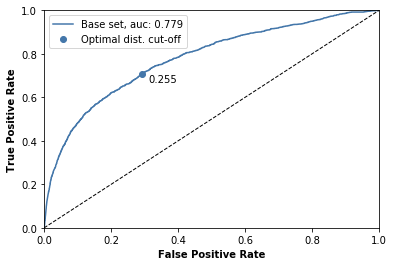

In [6]:
import numpy as np

plt.plot(fpr_b, tpr_b, label = "Base set"+", auc: "+str(round(auc_base, 3)), color = "#4477AA")
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1)

plt.ylabel("True Positive Rate", size=10, fontweight = "bold")
plt.xlabel("False Positive Rate", size=10, fontweight = "bold")
plt.xlim(0,1)
plt.ylim(0,1)

x = optimal.fpr.item()
y = optimal.tpr.item()
z = optimal.thresholds.item()

print(x,y,z)

plt.annotate(np.round(z,3), (x+0.02, y-0.04))
plt.plot(x, y, linestyle = "", marker = "o", color = "#4477AA", label = "Optimal dist. cut-off")
plt.legend()
plt.show()

# Prediction accuracy with genome selection by quality

In [114]:
#random sets 1000 x 50 species
#with fpr, tpr and auc values for roc
use_1000_ran = pd.read_csv("./auc_values_proteome_random_use_final", delimiter = "\t", header = None, index_col = 0, usecols = [0,3])

In [115]:
from scipy.spatial import distance
import copy
import numpy as np

#### Getting illogical absences 

#calculate the distances between interacting leca profiles
#remember, due to translations to OGs, the interactions can be between 
#the same OG pairs multiple times
#also, we do not want distances between the same OGs
#and we have redundancy back (A-->B and B-->A)

#get best interacting OG pairs 
#OG will be present only once in an interaction, with it's strongest co-evolving interactor
def interaction_BH(profile_leca, pos_set_leca): 
    dist_d = {}
    for idx in range(0, len(pos_set_leca)):
        OG_A = pos_set_leca.iloc[idx, 0]
        OG_B = pos_set_leca.iloc[idx, 1]
        if OG_A in profile_leca.index and OG_B in profile_leca.index:
            if OG_A != OG_B:
                profA = list(profile_leca.loc[OG_A,])
                profB = list(profile_leca.loc[OG_B,])
                dist = distance.cosine(profA, profB)
                if (OG_A, OG_B) not in dist_d:
                    if (OG_B, OG_A) not in dist_d:
                        dist_d[(OG_A,OG_B)] = dist

    #make dictionary more workable
    nr_dist_d = {}

    for (OG_A, OG_B) in dist_d:
        if OG_A in nr_dist_d:
            if OG_B not in nr_dist_d[OG_A]:
                nr_dist_d[OG_A][OG_B] = dist_d[(OG_A, OG_B)]
        else:
            nr_dist_d[OG_A] = {}
            nr_dist_d[OG_A][OG_B] = dist_d[(OG_A, OG_B)]


    A_list = list(nr_dist_d.keys())
    B_list = []
    for A, Bd in nr_dist_d.items():
        B_list += list(Bd.keys())

    print(len(A_list))
    print(len(B_list))

    all_list_dups = A_list + B_list #contains duplicates if A-->B and B-->C
    print(len(all_list_dups)) 
    all_list = list(dict.fromkeys(all_list_dups))#remove duplicates
    print(len(all_list))

    #make empty dataframe for filling
    df_dist = pd.DataFrame(index = all_list, columns = all_list)
    #fill the dataframe
    for A in nr_dist_d:
        for B in nr_dist_d[A]:
            distAB = nr_dist_d[A][B]
            df_dist.loc[A, B] = distAB
            df_dist.loc[B, A] = distAB
    #dataframe is all interacting OGs to be used to retrieve
    #best (lowest) distance pairs (row and column)


    #only keep upper diagonal of the distances
    #makes nan values zero...
    masked_df = df_dist.stack()#.where(np.triu(np.ones(df_dist.shape), k = 1).astype(np.bool)).stack()
    df_lt = df_dist#.where(np.triu(np.ones(df_dist.shape), k = 1).astype(np.bool))


    BH = {}
    while masked_df.size != 0: #check element size
        #get indeces with minimum distances in the dataframe
        minimum = np.where(masked_df.values == np.amin(masked_df.values))
        #Just pick the last one (no reason)
        min_i = minimum[0][0]#[-1]
        #print(masked_df.size, min_i, masked_df.index[min_i], masked_df.values[min_i])
        del_row = masked_df.index[min_i][0]
        del_col = masked_df.index[min_i][1]
        dist = masked_df.values[min_i]
        #print("Deleting: ", del_row, del_col, dist)
        df_lt = df_lt.drop(index = del_row, columns = del_col).drop(index = del_col, columns = del_row)
        masked_df = df_lt.stack()
        BH[(del_row, del_col)] = dist

    BH_profiles = {}
    for (A,B) in BH:
        #all interacting genes that lost their partner will be 1
        #0 if both absent and 2 when both are present
        profA =  list(profile_leca.loc[A,])
        profB =  list(profile_leca.loc[B,])
        diff = [el1 + el2 for (el1, el2) in zip(profA, profB)]
        BH_profiles[(A,B)] = diff

    #make a dataframe for useability later on
    BH_df = pd.DataFrame.from_dict(BH_profiles, orient = "index", columns = profile_leca.columns)
    return BH_df

In [116]:
#0 is co-absence of interacting OGs
#1 is absence of partner interacting OG
#2 interaction in present
BH_df_HSAP = interaction_BH(profile_leca, pos_set_leca)
BH_df_SCER = interaction_BH(profile_leca, pos_set_leca_SCER)

#Per species count interacting pair's illogical absences etc
def get_count_dict(BH_df):
    count_dict_species = {}
    for species in BH_df.columns:
        col = list(BH_df.loc[:,species].values)

        count_dict_species[species] = {"co-absence": col.count(0), "illogical-absence": col.count(1),\
                                      "present": col.count(2)}
    return count_dict_species
        
count_dict_species_HSAP = get_count_dict(BH_df_HSAP)
count_dict_species_SCER = get_count_dict(BH_df_SCER)


681
1781
2462
1168
975
4348
5323
1462


                                  co-absence  illogical-absence  present
Sphaeroforma arctica JP610                99                135      170
Creolimax fragrantissima                  44                 60      300
Capsaspora owczarzaki ATCC 30864          54                 80      270
Monosiga brevicollis MX1                  32                118      254
Salpingoeca rosetta                       33                 61      310


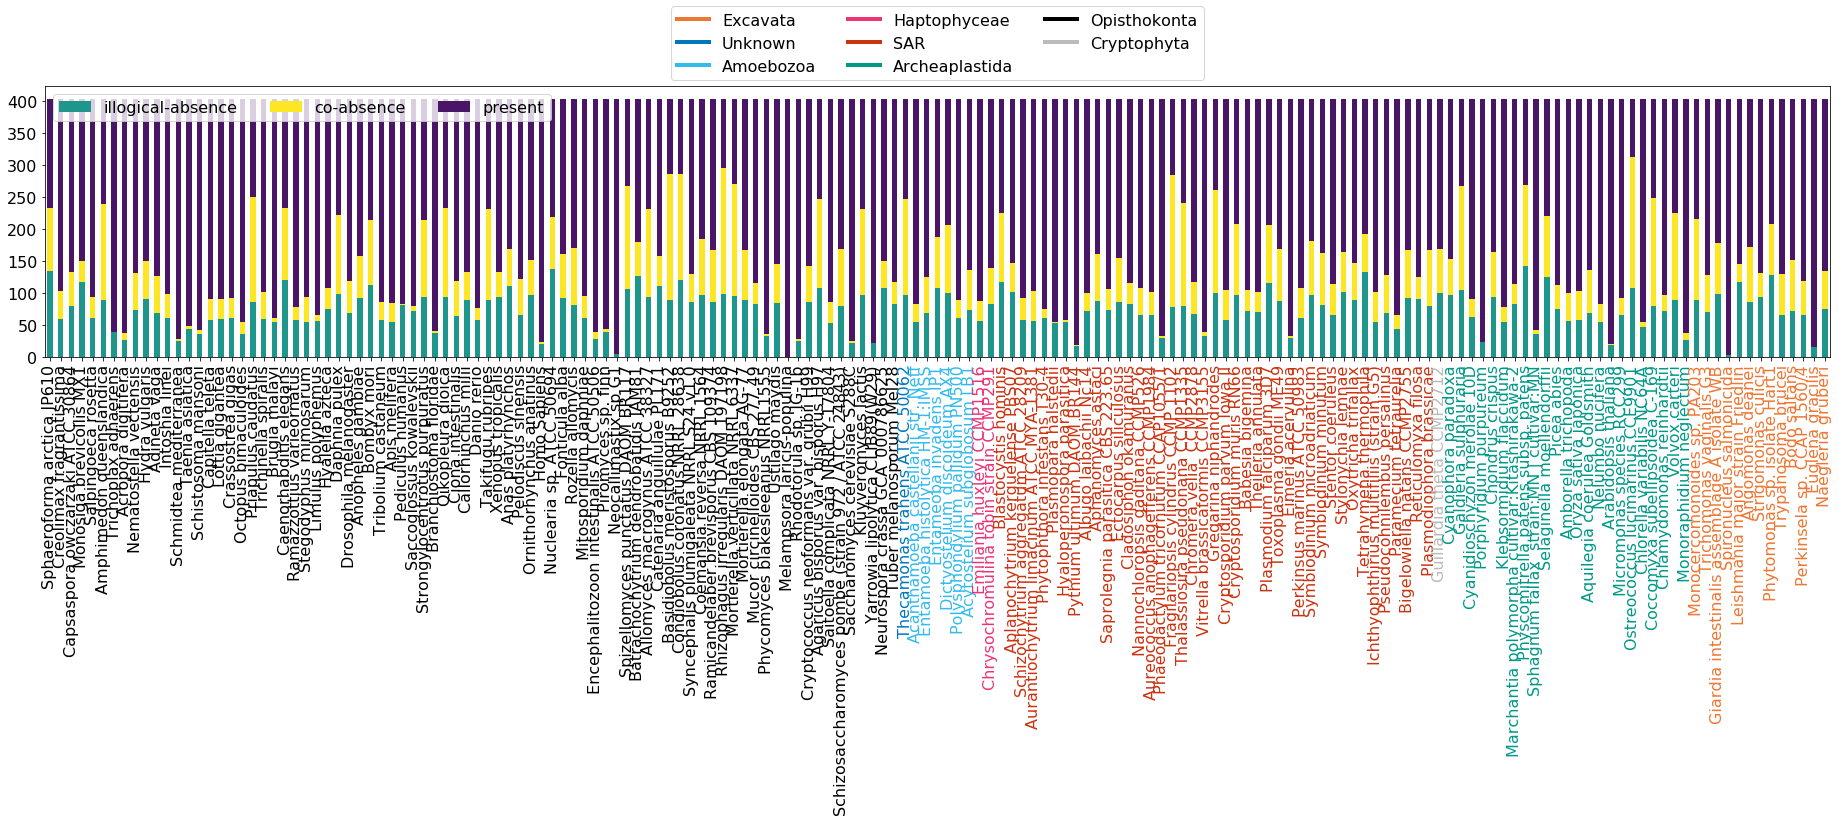

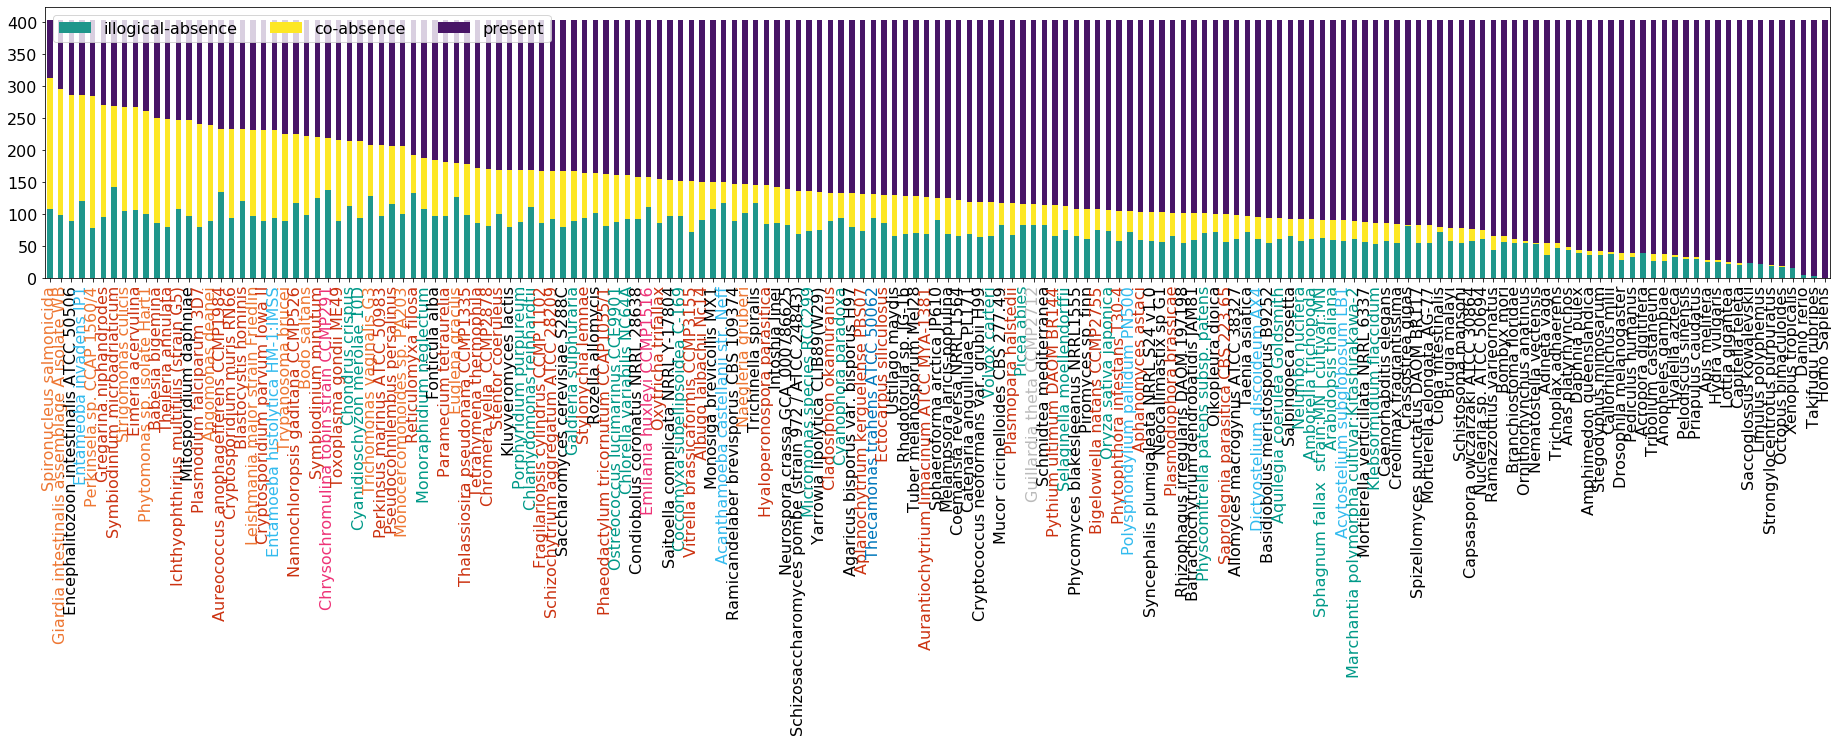

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df_s = pd.DataFrame(count_dict_species_HSAP).T

df_s.index = leaves
new_names = [species_names[x] for x in df_s.index]
df_s.index = new_names
print(df_s.head())


df_s.plot(y = ["illogical-absence", "co-absence", "present"], kind = "bar", stacked = True,\
          figsize=(32,5), color = ["#1F968BFF", "#FDE725FF","#481567FF"])


for i in range(0, len(plt.gca().get_xticklabels())):
    plt.gca().get_xticklabels()[i].set_color(color_list[i])
plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)
main_legend = plt.legend(prop={'size': 16}, loc="upper left", ncol = 3)

#add custom legend for supergroups
spg = [x for x in color_supergrd.keys()]
cls = [color_supergrd[x] for x in spg]
custom_lines = [Line2D([0], [0], color=cls[i], lw=4) for i in range(len(cls))]
custom_legend = plt.legend(custom_lines, spg, bbox_to_anchor=(0., 1.02, 1., .102), loc="lower center",
       ncol=3, borderaxespad=0., prop = {"size": 16})

plt.gca().add_artist(main_legend)

file_name='./ill_pres_co_tree_sorted_1.pdf'
plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format = 'pdf',transparent = True)


### Sorted accoring to presences
df_s = pd.DataFrame(count_dict_species_HSAP).T
df_s = df_s.sort_values("present")

color_list = []
color_list += [color_supergrd[supergroup_d[x]] for x in df_s.index]
new_names = [species_names[x] for x in df_s.index]
df_s.index = new_names

df_s.plot(y = ["illogical-absence", "co-absence", "present"], kind = "bar", stacked = True,\
          figsize=(32,5), color = ["#1F968BFF", "#FDE725FF","#481567FF"])


for i in range(0, len(plt.gca().get_xticklabels())):
    plt.gca().get_xticklabels()[i].set_color(color_list[i])

plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 16}, loc="upper left", ncol = 3)

file_name='./ill_pres_co_sorted_1.pdf'
plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format = 'pdf',transparent = True)


In [11]:
import statistics as s
#### 1. A. Using top x above median and 50 proteomes that are classified as good and bad by illogical absences
ill_df = pd.DataFrame(count_dict_species_HSAP).T
med_ill = s.median(ill_df["illogical-absence"]) #median value of illogical loss
#above median means more illogical loss and thus "bad" genomes
above_med_ill = list(ill_df[ill_df["illogical-absence"] > med_ill].index)
#below median means less illogical and this "better" genomes
below_med_ill = list(ill_df[ill_df["illogical-absence"] < med_ill].index)
sort_ill = ill_df["illogical-absence"].sort_values()

#lowest/least illogical 
lowest_50_ill = list(sort_ill.iloc[1:51,].index) #we do not want to include HSAP on 0
#highest/most illogical
highest_50_ill = list(sort_ill.iloc[-50:].index) #we do not want to include HSAP on 0

print(lowest_50_ill)
print(highest_50_ill)
print(len(lowest_50_ill), " bad genomes")
print(len(highest_50_ill), " good genomes")
print(sort_ill.head())
print(sort_ill.tail())

['TRUB', 'DRER', 'XTRO', 'OBIM', 'SPUR', 'CTEL', 'LPOL', 'LGIG', 'SKOW', 'HVUL', 'APIS', 'TCAS', 'AGAM', 'DMEL', 'PCAU', 'PSIN', 'PHUM', 'HAZT', 'AQUE', 'SMIM', 'AVAG', 'CMIL', 'ADIG', 'DPUL', 'APLA', 'RVAR', 'TADH', 'NVEC', 'KFLA', 'CFRA', 'RIRR', 'MELO', 'BFLO', 'OANA', 'SPUN', 'SMAN', 'BMER', 'SPAR', 'MVER', 'NSPE', 'BMOR', 'PINF', 'COWC', 'NNUC', 'SPLU', 'CELE', 'ASUB', 'BMAL', 'ATHA', 'BDEN']
['CPAI', 'ALAI', 'SARC', 'CCOR', 'SAGG', 'CVAR', 'SLEM', 'CPAR', 'CMUR', 'TTRA', 'CMER', 'EHIS', 'GNIP', 'FALB', 'SCOM', 'PMAR', 'MDAP', 'PTET', 'LMAJ', 'CSUB', 'GINT', 'BSAL', 'TPSE', 'SCOE', 'PHYT', 'MONO', 'NGRU', 'RALL', 'SCUL', 'EACE', 'SSAL', 'MNEG', 'MBRE', 'IMUL', 'EHUX', 'CREI', 'CCRI', 'PPER', 'NGAD', 'TSPI', 'ACAS', 'EINV', 'BHOM', 'SMIN', 'EGRA', 'TVAG', 'RFIL', 'AANO', 'CTOB', 'SMIC']
50  bad genomes
50  good genomes
HSAP     0
TRUB     4
DRER     5
XTRO    16
OBIM    18
Name: illogical-absence, dtype: int64
TVAG    129
RFIL    133
AANO    135
CTOB    138
SMIC    142
Name: illogi

In [ ]:
#RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
#Top highest illogical (bad) and lowest illogical absences (good)
top_ill_file = "./distance_sets/top_ill_dist"
get_distance_set(profile_leca, highest_50_ill, pos_set_leca, neg_set_leca, top_ill_file)

bot_ill_file = "./distance_sets/bot_ill_dist"
get_distance_set(profile_leca, lowest_50_ill, pos_set_leca, neg_set_leca, bot_ill_file)

In [12]:
top_ill_file = "./distance_sets/top_ill_dist"
bot_ill_file = "./distance_sets/bot_ill_dist"

fpr_top_ill, tpr_top_ill, auc_top_ill = get_roc_auc(top_ill_file)
fpr_bot_ill, tpr_bot_ill, auc_bot_ill = get_roc_auc(bot_ill_file)

print(auc_top_ill, auc_bot_ill)

0.7504909556997026 0.7761192737103734


In [13]:
ill_df2 = ill_df["illogical-absence"]/(ill_df["illogical-absence"] + ill_df["co-absence"])
ill_df2.sort_values(inplace = True) 
ill_df2 = ill_df2[~ill_df2.isna()]#don't take HSAP

lowest_frac_ill= list(ill_df2[0:50].index)
highest_frac_ill = list(ill_df2[-50:].index)

print(lowest_frac_ill)
print(highest_frac_ill)

['PERK', 'EINT', 'TANN', 'GINT', 'PFAL', 'BBIG', 'SSAL', 'GNIP', 'ADEA', 'PHYT', 'CPAI', 'SCUL', 'MDAP', 'TBRU', 'EACE', 'CMUR', 'EHIS', 'TGON', 'EINV', 'LMAJ', 'IMUL', 'CMER', 'BSAL', 'PMAR', 'KLAC', 'CVEL', 'VBRA', 'SCER', 'MONO', 'TTHE', 'PTRI', 'SPOM', 'UMAY', 'FCYL', 'PPUR', 'BHOM', 'NGAD', 'FALB', 'CCRI', 'SMIC', 'CNEO', 'GSUL', 'RSPE', 'RIRR', 'PTET', 'OLUC', 'ALIM', 'MSPE', 'CREV', 'PINF']
['CPAR', 'EHUX', 'MCIR', 'EGRA', 'PABI', 'SMAN', 'TTRA', 'MBRE', 'ODIO', 'SROS', 'SARC', 'GTHE', 'DMEL', 'SMED', 'AGAM', 'TCAS', 'TASI', 'COWC', 'BMAL', 'ACAS', 'TSPI', 'NUSP', 'AQUE', 'PHUM', 'BMOR', 'TADH', 'SMIM', 'HVUL', 'APIS', 'CTEL', 'LGIG', 'DPUL', 'CINT', 'BFLO', 'CMIL', 'PCAU', 'APLA', 'HAZT', 'OANA', 'PSIN', 'NVEC', 'OBIM', 'SPUR', 'LPOL', 'CGIG', 'TRUB', 'DRER', 'SKOW', 'ADIG', 'XTRO']


In [14]:
#in this case HSAP stays. With illogical absences this is biased because
#we use human interactions, for BUSCO this is not the case
busco_vals = species_absences["Busco_absences"].dropna().sort_values()
busco_vals = busco_vals[busco_vals.index.isin(profile_leca.columns)]
top_busco_abs = list(busco_vals[-50:].index)
bot_busco_abs = list(busco_vals[0:50].index)
print(top_busco_abs) #most busco absences
print(bot_busco_abs) #least according to busco
busco_vals

['EHUX', 'TTRA', 'TPSE', 'SMED', 'SLEM', 'NGRU', 'OLUC', 'RALL', 'TSPI', 'ACAS', 'CGIG', 'PTET', 'CCRI', 'SCOE', 'TTHE', 'TGON', 'PMAR', 'MNEG', 'NGAD', 'LMAJ', 'EGRA', 'PPER', 'TBRU', 'RFIL', 'SMIN', 'CMUR', 'AANO', 'MONO', 'BBIG', 'BHOM', 'BSAL', 'CPAI', 'MDAP', 'TVAG', 'PFAL', 'ADEA', 'SMIC', 'CTOB', 'EHIS', 'PHYT', 'TANN', 'SCUL', 'IMUL', 'EINT', 'PERK', 'GNIP', 'EACE', 'EINV', 'GINT', 'SSAL']
['DMEL', 'CREV', 'MELO', 'HSAP', 'MVER', 'SFAL', 'CELE', 'AGAM', 'ACOE', 'TRUB', 'SPUR', 'ATHA', 'ATRI', 'KFLA', 'DRER', 'CNEO', 'UMAY', 'TCAS', 'CTEL', 'PHUM', 'NNUC', 'TMEL', 'YLIP', 'BMER', 'APIS', 'RVAR', 'BMAL', 'MLAR', 'AQUE', 'HVUL', 'SMOE', 'SPUN', 'TADH', 'MPOL', 'NUSP', 'PPAT', 'OBIM', 'BDEN', 'AVAG', 'HAZT', 'SKOW', 'MCIR', 'CFRA', 'LGIG', 'RIRR', 'LPOL', 'DPUL', 'RSPE', 'SPLU', 'AMAC']


Species_ID
DMEL      0.0
CREV      0.0
MELO      0.0
HSAP      0.0
MVER      1.0
        ...  
GNIP    113.0
EACE    114.0
EINV    127.0
GINT    148.0
SSAL    164.0
Name: Busco_absences, Length: 167, dtype: float64

In [36]:
#RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
busco_file_top = "./distance_sets/top_BUSCO_dist"
get_distance_set(profile_leca, top_busco_abs, pos_set_leca, neg_set_leca, busco_file_top)

busco_file_bot = "./distance_sets/bot_BUSCO_dist"
get_distance_set(profile_leca, bot_busco_abs, pos_set_leca, neg_set_leca, busco_file_bot)

In [15]:
busco_file_top = "./distance_sets/top_BUSCO_dist"
fpr_busco_top, tpr_busco_top, auc_busco_top = get_roc_auc(busco_file_top)

busco_file_bot = "./distance_sets/bot_BUSCO_dist"
fpr_busco_bot, tpr_busco_bot, auc_busco_bot = get_roc_auc(busco_file_bot)

print(auc_busco_top,auc_busco_bot)

0.7478101674039871 0.7650349081188114


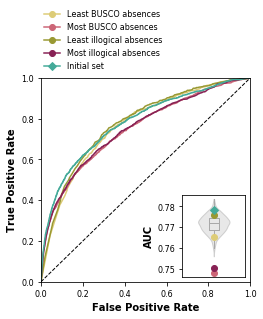

In [16]:
#data roc curves

data_d = {"Least BUSCO absences" : [fpr_busco_bot, tpr_busco_bot, auc_busco_bot],\
             "Most BUSCO absences": [fpr_busco_top, tpr_busco_top, auc_busco_top],\
             "Least illogical absences":[fpr_bot_ill, tpr_bot_ill, auc_bot_ill],\
             "Most illogical absences":[fpr_top_ill, tpr_top_ill, auc_top_ill],\
             "Initial set": [fpr_base, tpr_base, auc_base]}

#using the Tol color scheme
color = {"Least BUSCO absences" : "#DDCC77",\
             "Most BUSCO absences": "#CC6677",\
             "Least illogical absences":"#999933",\
             "Most illogical absences":"#882255",\
             "Initial set": "#44AA99"}

marker = {"Least BUSCO absences" : "o",\
             "Most BUSCO absences": "o",\
             "Least illogical absences":"o",\
             "Most illogical absences":"o",\
             "Initial set": "D"}

fig_size = (0.5*max_width,0.5*max_width)
fig, ax = plt.subplots(figsize = fig_size)
#function to plot roc curves
plot_rocs(ax, data_d, color, marker, use_1000_ran[3])

            Busco_absences  illogical-absence  leca_retained
Species_ID                                                  
AANO                  71.0                135           4009
AAST                  11.0                 60           5137
ABIS                  10.0                 80           3759
ACAS                  38.0                118           5201
ACOE                   1.0                 61           4889


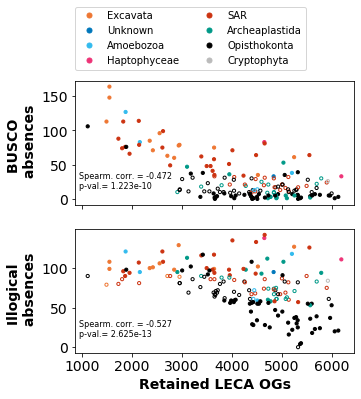

In [16]:
from matplotlib.lines import Line2D
import scipy.stats as ss

IA = pd.DataFrame(count_dict_species_HSAP).T.loc[:,"illogical-absence"]

LR = pd.DataFrame(profile_leca.sum()) #retained LECA OGs per genome
LR = LR[LR.index.isin(IA.index)]
LR.columns = ["leca_retained"]

BA = species_absences["Busco_absences"]
BA = BA[BA.index.isin(IA.index)]

merged = pd.DataFrame(BA).join(pd.DataFrame(IA)).join(pd.DataFrame(LR))
print(merged.head())

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (5,5))

color_list = []
color_list += [color_supergrd[supergroup_d[x]] for x in merged.index]
alpha_list_I = [color_supergrd[supergroup_d[x]] if x in highest_50_ill + lowest_50_ill else 'none' for x in list(merged.index)]
alpha_list_B = [color_supergrd[supergroup_d[x]] if x in top_busco_abs + bot_busco_abs else 'none' for x in list(merged.index)]


ax1.scatter(merged["leca_retained"], merged["Busco_absences"],\
            color = color_list, facecolor = alpha_list_B,\
            s = 10, label = list(color_supergrd.keys()))

scor_busco = ss.spearmanr(merged["leca_retained"], merged["Busco_absences"])

ax1.annotate('Spearm. corr. = '+str(round(scor_busco[0], 3))+"\n" + "p-val.= "+ str('{:0.3e}'.format(scor_busco[1])),
            xy=(.015, .13), xycoords='axes fraction',
            fontsize=8)

ax1.set_ylabel("BUSCO \n absences", fontsize = 14, fontweight = "bold")
ax1.set_xticklabels([""])
ax1.grid(False)

plt.setp(ax1.get_yticklabels(), fontsize=14)

#ax1.set_yticklabels(fontsize = 14)

ax2.scatter(merged["leca_retained"], merged["illogical-absence"],\
            color = color_list, facecolor = alpha_list_I,\
            s = 10, label = list(color_supergrd.keys()))

scor_ill = ss.spearmanr(merged["leca_retained"], merged["illogical-absence"])

ax2.annotate('Spearm. corr. = '+str(round(scor_ill[0], 3))+"\n" + "p-val.= "+ str('{:0.3e}'.format(scor_ill[1])),
            xy=(.015, .13), xycoords='axes fraction',
            fontsize=8)

ax2.set_xlabel("Retained LECA OGs", fontsize = 14, fontweight = "bold")
ax2.set_ylabel("Illogical \n absences", fontsize = 14, fontweight = "bold")
ax2.grid(False)
plt.xticks(fontsize = 14)
plt.setp(ax2.get_yticklabels(), fontsize=14)

#custom legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', markersize = 5) for color in color_supergrd.values()]
plt.legend(markers, color_supergrd.keys(), ncol = 2, numpoints=1,  bbox_to_anchor = (0., 2.7, 1., .102), borderaxespad=0., loc='upper left')



            Busco_absences  leca_retained
Species_ID                               
AANO                  71.0           4009
AAST                  11.0           5137
ABIS                  10.0           3759
ACAS                  38.0           5201
ACOE                   1.0           4889


/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


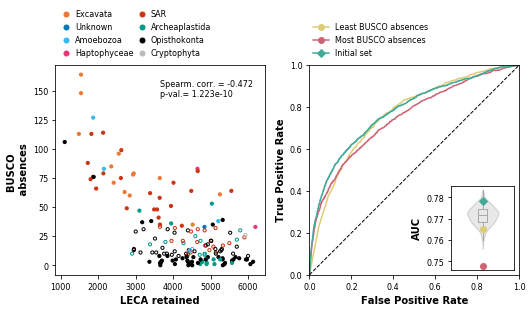

In [17]:
##### Manuscript main figure
#data roc curves
from matplotlib.lines import Line2D
import scipy.stats as ss

data_d = {"Least BUSCO absences" : [fpr_busco_bot, tpr_busco_bot, auc_busco_bot],\
             "Most BUSCO absences": [fpr_busco_top, tpr_busco_top, auc_busco_top],\
             "Initial set": [fpr_base, tpr_base, auc_base]}

#using the Tol color scheme
color = {"Least BUSCO absences" : "#DDCC77",\
             "Most BUSCO absences": "#CC6677",\
             "Initial set": "#44AA99"}

marker = {"Least BUSCO absences" : "o",\
             "Most BUSCO absences": "o",\
             "Initial set": "D"}


LR = pd.DataFrame(profile_leca.sum()) #retained LECA OGs per genome
#LR = LR[LR.index.isin(IA.index)]
LR.columns = ["leca_retained"]

BA = species_absences["Busco_absences"]
BA = BA[BA.index.isin(LR.index)]

merged = pd.DataFrame(BA).join(pd.DataFrame(LR))

print(merged.head())
fig_size = (max_width,0.75*max_width)
fig, ax1 = plt.subplots(1,2, figsize = fig_size)

color_list = []
color_list += [color_supergrd[supergroup_d[x]] for x in merged.index]
alpha_list_B = [color_supergrd[supergroup_d[x]] if x in top_busco_abs + bot_busco_abs else 'none' for x in list(merged.index)]

ax1[0].scatter(merged["leca_retained"], merged["Busco_absences"],\
                color = color_list, facecolor = alpha_list_B,\
                s = 10, label = list(color_supergrd.keys()))

scor_busco = ss.spearmanr(merged["leca_retained"], merged["Busco_absences"])

ax1[0].annotate('Spearm. corr. = '+str(round(scor_busco[0], 3))+"\n" + "p-val.= "+ str('{:0.3e}'.format(scor_busco[1])),
                xy=(.5, .85), xycoords='axes fraction',
                fontsize=8)

ax1[0].set_ylabel("BUSCO \n absences", fontsize = 10, fontweight = "bold")
ax1[0].set_xlabel("LECA retained", fontsize = 10, fontweight = "bold")


ax1[0].grid(False)
ax1[0].set_aspect(1./ax1[0].get_data_ratio())
plt.setp(ax1[0].get_xticklabels(), fontsize=8)
plt.setp(ax1[0].get_yticklabels(), fontsize=8)

#custom legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', markersize = 5) for color in color_supergrd.values()]
ax1[0].legend(markers, color_supergrd.keys(), ncol = 2, handletextpad=0.1,\
            bbox_to_anchor = (0., 1.02), columnspacing = 0.,prop={'size': 8},\
            borderaxespad = 0., loc='lower left', frameon=False)

#wrap_busco_plot(ax1[0], merged, color_supergrd, color_list)
plot_rocs(ax1[1], data_d, color, marker, use_1000_ran[3])
#labelling subplots
names = ["A.", "B."]
for axi in range(len(ax1)):
    #ax1[axi].text(-0.2, 1.3, names[axi], ha="left", va="top", transform=ax1[axi].transAxes, weight='semibold', size = 12)
    ax1[axi].set_aspect(1./ax1[axi].get_data_ratio())
plt.tight_layout()

#save plot to figure
plt.savefig("Figure1.pdf", bbox_inches = 'tight',pad_inches = 0)

      illogical-absence  leca_retained
AANO                135           4009
AAST                 60           5137
ABIS                 80           3759
ACAS                118           5201
ACOE                 61           4889


/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


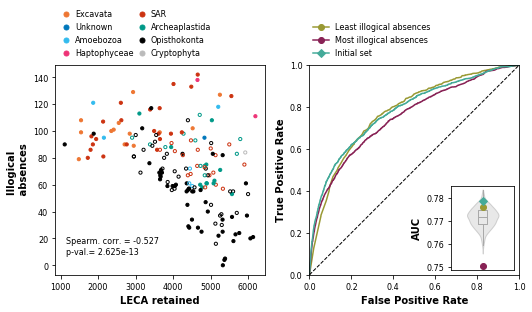

In [20]:
##### Manuscript main figure
#data roc curves
from matplotlib.lines import Line2D
import scipy.stats as ss

data_d = {"Least illogical absences":[fpr_bot_ill, tpr_bot_ill, auc_bot_ill],\
             "Most illogical absences":[fpr_top_ill, tpr_top_ill, auc_top_ill],\
             "Initial set": [fpr_base, tpr_base, auc_base]}

#using the Tol color scheme
color = {"Least illogical absences":"#999933",\
             "Most illogical absences":"#882255",\
             "Initial set": "#44AA99"}

marker = {"Least illogical absences":"o",\
             "Most illogical absences":"o",\
             "Initial set": "D"}

IA = pd.DataFrame(count_dict_species_HSAP).T.loc[:,"illogical-absence"]

LR = pd.DataFrame(profile_leca.sum()) #retained LECA OGs per genome
LR = LR[LR.index.isin(IA.index)]
LR.columns = ["leca_retained"]



merged = pd.DataFrame(IA).join(pd.DataFrame(LR))
print(merged.head())

fig_size = (max_width,0.75*max_width)
fig, ax1 = plt.subplots(1,2, figsize = fig_size)

color_list = []
color_list += [color_supergrd[supergroup_d[x]] for x in merged.index]
alpha_list_B = [color_supergrd[supergroup_d[x]] if x in top_busco_abs + bot_busco_abs else 'none' for x in list(merged.index)]

ax1[0].scatter(merged["leca_retained"], merged["illogical-absence"],\
                color = color_list, facecolor = alpha_list_B,\
                s = 10, label = list(color_supergrd.keys()))

scor_ill = ss.spearmanr(merged["leca_retained"], merged["illogical-absence"])

ax1[0].annotate('Spearm. corr. = '+str(round(scor_ill[0], 3))+"\n" + "p-val.= "+ str('{:0.3e}'.format(scor_ill[1])),
            xy=(.05, .1), xycoords='axes fraction',
            fontsize=8)

ax1[0].set_ylabel("Illogical \n absences", fontsize = 10, fontweight = "bold")
ax1[0].set_xlabel("LECA retained", fontsize = 10, fontweight = "bold")


ax1[0].grid(False)
ax1[0].set_aspect(1./ax1[0].get_data_ratio())
plt.setp(ax1[0].get_xticklabels(), fontsize=8)
plt.setp(ax1[0].get_yticklabels(), fontsize=8)

#custom legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', markersize = 5) for color in color_supergrd.values()]
ax1[0].legend(markers, color_supergrd.keys(), ncol = 2, handletextpad=0.1,\
            bbox_to_anchor = (0., 1.02), columnspacing = 0.,prop={'size': 8},\
            borderaxespad = 0., loc='lower left', frameon=False)

#wrap_busco_plot(ax1[0], merged, color_supergrd, color_list)
plot_rocs(ax1[1], data_d, color, marker, use_1000_ran[3])
#labelling subplots
names = ["A.", "B."]
for axi in range(len(ax1)):
    #ax1[axi].text(-0.2, 1.3, names[axi], ha="left", va="top", transform=ax1[axi].transAxes, weight='semibold', size = 12)
    ax1[axi].set_aspect(1./ax1[axi].get_data_ratio())
plt.tight_layout()

#save plot to figure
plt.savefig("SupplementaryFig1.pdf", bbox_inches = 'tight',pad_inches = 0)

# Prediction accuracy with genome selection by diversity

In [18]:
#pairwiawcorrelations between genomes/columns
corr_mat = profile_leca.T.corr(method='pearson')

In [19]:
#Clustering with own method (EvaCC)
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.cm as cm

###Own metric for most dissimilar and similar species sets
#for every pairwise distance
#get the min of max value for similarity/dissimilarity
#to get the most dissimilar and similar set, we need to compare species in the set and the ones coming into the set
#so if A and B as most similar/dissimilar, we add this to the list
#if A and C then most similar/dissimilar, we check if C is also above threshold of similirity/dissimilarity
#before we add C to the set as well. 
dist_df = pd.DataFrame(pairwise_distances(profile_leca.T, metric = 'cosine'), index = profile_leca.columns, columns = profile_leca.columns)

dist_stacked = dist_df.where(np.triu(np.ones(dist_df.shape), k=1).astype(np.bool)).stack()
thresh_sim = 0.58 * dist_stacked.max()
thresh_dissim = 0.38 * dist_stacked.max()

print("thresh: ", thresh_sim, thresh_dissim)

most_dissim_dist = dist_stacked[dist_stacked >= thresh_dissim]
print(len(most_dissim_dist))
most_sim_dist = dist_stacked[dist_stacked <= thresh_sim]   
print(len(most_sim_dist))

genome_num = 50

most_dissimilar = []
i = 0
while len(most_dissimilar) < genome_num:
    i += 1
    species_pair = most_dissim_dist.idxmax()
    s1 = species_pair[0]
    s2 = species_pair[1]
    
    #print(i, s1, s2)
    if not most_dissimilar: #if empty
        most_dissimilar += [s1, s2] #initialize
        
    sx_list = []
    if s2 not in most_dissimilar:
        for sx in most_dissimilar:
            #print(s2, sx)
            if most_dissim_dist.index.isin([(sx,s2)]).any() or most_dissim_dist.index.isin([(s2,sx)]).any():
                sx_list += [True]
            else:
                sx_list += [False]
    #print("s2:", sx_list)
        if np.all(sx_list): #only is all combinations are above threshold
            most_dissimilar += [s2]
    
    sx_list = []
    if s1 not in most_dissimilar:
        for sx in most_dissimilar:
            #print(s1, sx)
            if most_dissim_dist.index.isin([(sx,s1)]).any() or most_dissim_dist.index.isin([(s1,sx)]).any():
                sx_list += [True]
            else:
                sx_list += [False]
            #print("s1:", sx_list)
        if np.all(sx_list): #only is all combinations are above threshold
            most_dissimilar += [s1]
    
    most_dissim_dist[species_pair] = "NaN"
    
print(most_dissimilar)


most_similar = []
while len(most_similar) < genome_num:
    
    species_pair = most_sim_dist.idxmin()
    s1 = species_pair[0]
    s2 = species_pair[1]

    if not most_similar: #if empty
        most_similar += [s1, s2] #initialize
        print(most_similar)
        
    sx_list = []
    if s2 not in most_similar:
        for sx in most_similar:
            #print(s2, sx)
            if most_sim_dist.index.isin([(sx,s2)]).any() or most_sim_dist.index.isin([(s2,sx)]).any():
                sx_list += [True]
            else:
                sx_list += [False]
    #print("s2:", sx_list)
        if np.all(sx_list): #only is all combinations are above threshold
            most_similar += [s2]
    
    sx_list = []
    if s1 not in most_similar:
        for sx in most_similar:
            #print(s1, sx)
            if most_sim_dist.index.isin([(sx,s1)]).any() or most_sim_dist.index.isin([(s1,sx)]).any():
                sx_list += [True]
            else:
                sx_list += [False]
            #print("s1:", sx_list)
        if np.all(sx_list): #only is all combinations are above threshold
            most_similar += [s1]
    
    most_sim_dist[species_pair] = "NaN"

thresh:  0.4021368036056097 0.2634689402933305
12612
7640
['EINT', 'SMIC', 'EGRA', 'CTOB', 'EINV', 'SSAL', 'NUSP', 'ACAS', 'EHUX', 'PABI', 'MNEG', 'SARC', 'CPAR', 'MDAP', 'COKA', 'RFIL', 'GTHE', 'AANO', 'FCYL', 'BNAT', 'CGIG', 'CVEL', 'NGAD', 'PERK', 'SMED', 'SCOM', 'PPUR', 'TSPI', 'CVAR', 'TTRA', 'AKER', 'SPAR', 'PPAL', 'MBRE', 'COWC', 'TANN', 'BSAL', 'MSPE', 'MONO', 'NGRU', 'GNIP', 'CPAI', 'BHOM', 'EACE', 'TVAG', 'PMAR', 'PPER', 'FALB', 'SCUL', 'ILIN']
['ATHA', 'NNUC']


/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


['SPAR', 'PPAL']


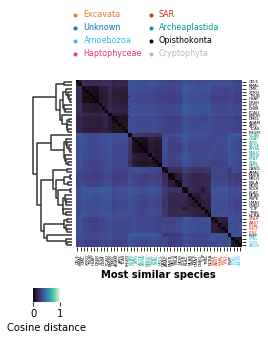

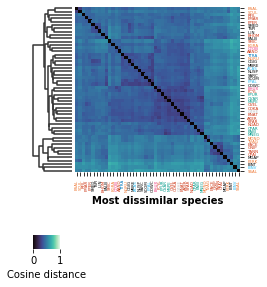

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

most_sim_df = dist_df.loc[most_similar,most_similar]
most_dissim_df = dist_df.loc[most_dissimilar,most_dissimilar]


c1 = sns.clustermap(most_sim_df, vmin=0, vmax=1, cbar_pos=(0.05, -0.025, 0.1, 0.05),\
                    cbar_kws={'label': 'Cosine distance', 'orientation':'horizontal'},\
                    figsize = (0.5*max_width,0.5*max_width), cmap = "mako",\
                    xticklabels=1, yticklabels = 1)

labs_sim = [species_names[item.get_text()] for item in c1.ax_heatmap.yaxis.get_majorticklabels()]
#c1.ax_heatmap.axes.set_yticklabels(labs_sim)


#legend custom made
handles = [Line2D([], [],color=color_supergrd[supergroup], marker = ".", linestyle = "None") for supergroup in color_supergrd.keys()]
l1 = plt.legend(handles, color_supergrd, ncol = 2, columnspacing = 0.1,\
           bbox_to_anchor=(0.15, 0.85, 1., .102), loc='lower left', handletextpad=0.,\
           bbox_transform=plt.gcf().transFigure, frameon=False, prop = {"size": 8})
#just text in legend colored
for text in l1.get_texts():
    text.set_color(color_supergrd[text.get_text()])

c2 = sns.clustermap(most_dissim_df, vmin=0, vmax=1, cbar_pos=(0.05, -0.1, 0.1, 0.05),\
                    cbar_kws={'label': 'Cosine distance', 'orientation':'horizontal'},\
                    figsize = (0.5*max_width,0.5*max_width), cmap = "mako",\
                    xticklabels=1, yticklabels = 1)
labs_dissim = [species_names[item.get_text()] for item in c2.ax_heatmap.yaxis.get_majorticklabels()]
#c2.ax_heatmap.axes.set_yticklabels(labs_sim) 


for c in [c1,c2]:
    for tick_label in c.ax_heatmap.axes.get_yticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(color_supergrd[supergroup_d[tick_text]])
        tick_label.set_fontsize(4)
        
    for tick_label in c.ax_heatmap.axes.get_xticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(color_supergrd[supergroup_d[tick_text]])
        tick_label.set_fontsize(4)
    c.ax_col_dendrogram.set_visible(False)

    for a in c.ax_row_dendrogram.collections:
        a.set_linewidth(1.5)
#c1.ax_heatmap.set_title('Similar species')
#c2.ax_heatmap.set_title('Dissimilar species')

c1.ax_heatmap.set_xlabel("Most similar species", fontsize = 10, fontweight = "bold")
c2.ax_heatmap.set_xlabel("Most dissimilar species", fontsize = 10, fontweight = "bold")

#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left')
#test to see if it worked and how it looks
overlap_list = list(dist_df.loc[most_similar,most_similar].index[dist_df.loc[most_similar,most_similar].index.isin(dist_df.loc[most_dissimilar,most_dissimilar].index)])
print(overlap_list)
#save plot to figure
c1.savefig("Figure2A.pdf", bbox_inches = 'tight',pad_inches = 0)
c2.savefig("Figure2B.pdf", bbox_inches = 'tight',pad_inches = 0)

In [531]:
#RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
evac_dissim_file = "./distance_sets/evac_dissim_dist"
get_distance_set(profile_leca, most_dissimilar, pos_set_leca, neg_set_leca, evac_dissim_file)

evac_sim_file = "./distance_sets/evac_sim_dist"
get_distance_set(profile_leca, most_similar, pos_set_leca, neg_set_leca, evac_sim_file)

In [26]:
evac_dissim_file = "./distance_sets/evac_dissim_dist"
fpr_evac_dissim, tpr_evac_dissim, auc_evac_dissim = get_roc_auc(evac_dissim_file)
print(auc_evac_dissim)

evac_sim_file = "./distance_sets/evac_sim_dist"
fpr_evac_sim, tpr_evac_sim, auc_evac_sim = get_roc_auc(evac_sim_file)
print(auc_evac_sim)

0.7596174484618239
0.7636469336965839


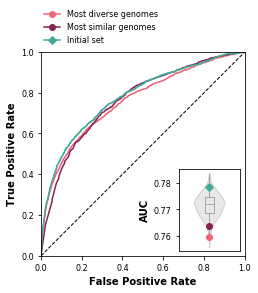

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as s
import matplotlib.lines as mlines


data_evac = {"Most diverse genomes" : [fpr_evac_dissim, tpr_evac_dissim, auc_evac_dissim],\
             "Most similar genomes":[fpr_evac_sim, tpr_evac_sim, auc_evac_sim],\
             "Initial set": [fpr_base, tpr_base, auc_base]}

#using the Tol color scheme
color = {"Most diverse genomes" :"#EE6677",\
             "Most similar genomes":"#882255",\
             "Initial set": "#44AA99"}

marker = {"Most diverse genomes" :"o",\
             "Most similar genomes":"o",\
             "Initial set": "D"}
fig_size = (0.5*max_width,0.5*max_width)
fig, ax = plt.subplots(figsize = fig_size)
plot_rocs(ax, data_evac, color, marker, use_1000_ran[3])
ax.set_aspect(1./ax.get_data_ratio())
plt.savefig("Figure2C.pdf", bbox_inches = 'tight',pad_inches = 0)

# Prediction accuracy by random sampling

In [177]:
# Randomly removing proteomes 1 by 1
random_rem = pd.read_csv("auc_values_proteome_removal", delimiter = "\t", header = None, index_col = 0,usecols = [0,1])
print(random_rem[1])

#random_rem_SCER = pd.read_csv("auc_values_proteome_removal_SCER", delimiter = "\t", header = None, index_col = 0,usecols = [0,1])
#print(random_rem_SCER[1])

0
AANO    0.778717
AAST    0.778830
ABIS    0.778407
ACAS    0.778453
ACOE    0.778451
          ...   
UMAY    0.778737
VBRA    0.778781
VCAR    0.778719
XTRO    0.778474
YLIP    0.778557
Name: 1, Length: 167, dtype: float64


In [178]:
def best_worst_set (random_rem):
    #remove base set value
    sorted_rem = random_rem.iloc[1:,0].sort_values(ascending = False, inplace = False)
    best = sorted_rem.iloc[-50:]
    worst = sorted_rem.iloc[0:50]
    return best, worst

#HSAP set best and worst
#best genomes reduce auc when removed
#worst genomes increase auc when removed
best, worst = best_worst_set(random_rem)
#SCER set best and worst
#best_SCER, worst_SCER = best_worst_set(random_rem_SCER)


In [24]:
for x in best.index:
    print(x, species_names[x])
print("______")
for x in worst.index:
    print(x, species_names[x])

MDAP Mitosporidium daphniae
CINT Ciona intestinalis
GNIP Gregarina niphandrodes
ABIS Agaricus bisporus var. bisporus H97
OBIM Octopus bimaculoides
OANA Ornithorhynchus anatinus
CELE Caenorhabditis elegans
ATHA Arabidopsis thaliana
SCOE Stentor coeruleus
PFAL Plasmodium falciparum 3D7
SPOM Schizosaccharomyces pombe (strain 972 / ATCC 24843)
GINT Giardia intestinalis assemblage A isolate WB
RALL Rozella allomycis
SMIM Stegodyphus mimosarum
SPLU Syncephalis plumigaleata NRRL S24 v1.0
OLUC Ostreococcus lucimarinus CCE9901
BBIG Babesia bigemina
CMUR Cryptosporidium muris RN66
SSAL Spironucleus salmonicida
AQUE Amphimedon queenslandica
GSUL Galdieria sulphuraria
CFRA Creolimax fragrantissima
CMER Cyanidioschyzon merolae 10D
SMED Schmidtea mediterranea
CPAI Cryptosporidium parvum Iowa II
MONO Monocercomonoides sp. PA203
TANN Theileria annulata
LPOL Limulus polyphemus
PCAU Priapulus caudatus
DPUL Daphnia pulex
NUSP Nuclearia sp. ATCC 50694
COWC Capsaspora owczarzaki ATCC 30864
PERK Perkinsela 

0
AANO    0.778717
AAST    0.778830
ABIS    0.778407
ACAS    0.778453
ACOE    0.778451
          ...   
UMAY    0.778737
VBRA    0.778781
VCAR    0.778719
XTRO    0.778474
YLIP    0.778557
Name: 1, Length: 167, dtype: float64
0.001269166126288468


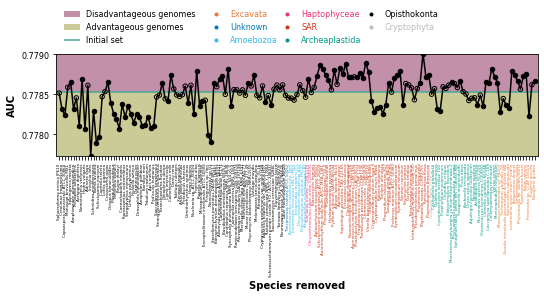

In [31]:
import statistics as s
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig = plt.figure(figsize = (1.15*max_width,0.25*max_width))
ax = fig.add_subplot()

y = random_rem.iloc[0:,0]
print(y)
y = y.loc[[leaf for leaf in leaves if leaf in y.index]] #order accroding to tree
print(y.max() - y.min())

color_list = []
color_list += [color_supergrd[supergroup_d[x]] for x in y.index]

x_best = [species_names[x] for x in y.index if x in best]
x_worst = [species_names[x] for x in y.index if x in worst]
x_mark = x_best + x_worst
y.index = [species_names[x] for x in y.index] #rename species id
x = y.index

nulline = auc_base#random_rem.iloc[0,0]
median = s.median(random_rem.iloc[1:,0])

plt.xlim(-1, 167)
plt.ylim(min(y), max(y))
plt.xlabel("Species removed", fontsize = 10, fontweight = "bold")
plt.ylabel("AUC", fontsize = 10, fontweight = "bold")
plt.xticks(rotation = 90, fontsize = 4)
plt.yticks(fontsize = 8)

#baseline
plt.hlines(nulline, xmin = -1, xmax = 1001, color = "#44AA99", label = "Initial set")
#plt.hlines(median, xmin = -1, xmax = 1001, color = "black", linestyle = "--", label = "Median")

#annotation boxes
plt.axhspan(nulline, max(y), 0, 1, facecolor="#882255", alpha=0.5, label = "Disadvantageous genomes", zorder = 1)
plt.axhspan(min(y), nulline, 0, 1, facecolor="#999933", alpha=0.5, label = "Advantageous genomes", zorder = 1)
leg1 = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', prop = {"size": 8}, frameon = False)

#line and scatterplot
plt.plot(x, y, color = "black", zorder = 2)
for xm in x:
    if xm in x_mark:
        plt.scatter(xm, y[xm], color = "black", marker = "o", facecolors = "black", zorder = 3, s = 20)
    else:
        plt.scatter(xm, y[xm], color = "black", marker = "o", facecolors = "none", zorder = 3, s = 20)


#color species labels
for i in range(0, len(plt.gca().get_xticklabels())):
    plt.gca().get_xticklabels()[i].set_color(color_list[i])


#legend custom made
handles = [Line2D([], [],color=color_supergrd[supergroup], marker = ".", linestyle = "None") for supergroup in color_supergrd.keys()]
l1 = plt.legend(handles, color_supergrd, ncol = 3, columnspacing = 0.1,\
           bbox_to_anchor=(0.3, 1.02, 1., .102), loc='lower left',\
           frameon=False, prop = {"size": 8})
#just text in legend colored
for text in l1.get_texts():
    text.set_color(color_supergrd[text.get_text()])

ax.add_artist(leg1)


fig.savefig("Figure3A.pdf", bbox_inches = 'tight',pad_inches = 0)


In [112]:
#RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
best_auc_file = "./distance_sets/best_auc_dist"
get_distance_set(profile_leca, best.index, pos_set_leca, neg_set_leca, best_auc_file)

worst_auc_file = "./distance_sets/worst_auc_dist"
get_distance_set(profile_leca, worst.index, pos_set_leca, neg_set_leca, worst_auc_file)

In [32]:
best_auc_file = "./distance_sets/best_auc_dist"
fpr_best, tpr_best, auc_best = get_roc_auc(best_auc_file)
print(auc_best)

worst_auc_file = "./distance_sets/worst_auc_dist"
fpr_worst, tpr_worst, auc_worst = get_roc_auc(worst_auc_file)
print(auc_worst)

0.8012579664197312
0.7301429261265


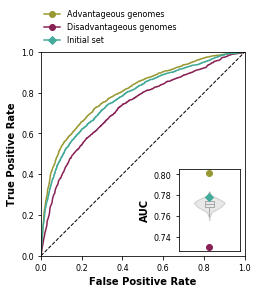

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as s
import matplotlib.lines as mlines

data_d = {"Advantageous genomes": [fpr_best, tpr_best, auc_best],\
             "Disadvantageous genomes": [fpr_worst, tpr_worst, auc_worst],\
             "Initial set": [fpr_base, tpr_base, auc_base]}

#using the Tol color scheme
color = {"Advantageous genomes": "#999933",\
             "Disadvantageous genomes": "#882255",\
             "Initial set": "#44AA99"}

marker = {"Advantageous genomes": "o",\
             "Disadvantageous genomes": "o",\
             "Initial set": "D"}

fig_size = (0.5*max_width,0.5*max_width)
fig, ax = plt.subplots(figsize = fig_size)
plot_rocs(ax, data_d, color, marker, use_1000_ran[3])
#ax.text(-0.2, 1.3, "C.", ha="left", va="top", transform=ax.transAxes, weight='semibold', size = 12)
ax.set_aspect(1./ax.get_data_ratio())
fig.savefig("Figure3B.pdf", bbox_inches = 'tight',pad_inches = 0)


6356.17661228929
     level_0 level_1         0
740     SSAL    NUSP  0.193954
502     GINT    NUSP  0.228302
332     ATHA    SSAL  0.266609
563     SMIM    SSAL  0.266921
731     SSAL    CFRA  0.271574
...      ...     ...       ...
1089    TCAS    DMEL  0.885083
1216    PSPF    NSPE  0.894942
673     BBIG    TANN  0.912828
1110    DMEL    AGAM  0.931238
703     CMUR    CPAI  0.933039

[1225 rows x 3 columns]
614.6910479901533
    level_0 level_1         0
412    FALB    SMIC  0.228201
700    SMIC    CMIL  0.236593
713    SMIC    NVEC  0.242297
721    SMIC    CGIG  0.243369
289    CCOR    SMIC  0.245363
..      ...     ...       ...
682    PINF    PHAL  0.852125
371    PULT    PINF  0.858218
200    AAST    SPAR  0.865289
857    CANG    AMAC  0.868302
496    LMAJ    TBRU  0.895214

[1225 rows x 3 columns]
558.0349063953124


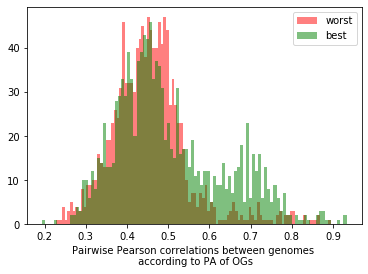

In [36]:
import numpy as np
import matplotlib.pyplot as plt

all_corr = profile_leca.corr(method='pearson')
all_upper = all_corr.where(np.triu(np.ones(all_corr.shape), k = 1).astype(np.bool))
all_stacked = all_upper.stack().reset_index()
all_sum = sum(all_stacked[0])
print(all_sum)

best_df = profile_leca[best.index]
best_corr = best_df.corr(method='pearson')
worst_df = profile_leca[worst.index]
worst_corr = worst_df.corr(method='pearson')

best_upper = best_corr.where(np.triu(np.ones(best_corr.shape), k = 1).astype(np.bool)) #symmetric matrix, everything above the diagonal
#print(best_upper)
best_stacked = best_upper.stack().reset_index()
best_sum = sum(best_stacked[0])
print(best_stacked.sort_values(by = 0))
print(best_sum)

worst_upper = worst_corr.where(np.triu(np.ones(worst_corr.shape), k = 1).astype(np.bool)) #symmetric matrix, everything above the diagonal
#print(best_upper)
worst_stacked = worst_upper.stack().reset_index()
worst_sum = sum(worst_stacked[0])
print(worst_stacked.sort_values(by = 0))

print(worst_sum)

plt.hist(worst_stacked[0], bins = 100, label = "worst", alpha = 0.5, color = "red")
plt.hist(best_stacked[0], bins = 100, label = "best", alpha = 0.5, color = "green")
#plt.hist(all_stacked[0], bins = 1000, label = "base", alpha = 0.5, color = "orange")
plt.xlabel("Pairwise Pearson correlations between genomes \n according to PA of OGs")
plt.legend()

#plt.show()
file_name = "corr_best_worst.pdf"
plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format = 'pdf',transparent = True)



In [37]:
print(all_corr.loc["HSAP",][leaves])
print(sorted(list(worst.index)))
print(sorted(list(best.index)))

SARC    0.435951
CFRA    0.563707
COWC    0.633555
MBRE    0.573949
SROS    0.631960
          ...   
TBRU    0.456596
BSAL    0.414909
PERK    0.359089
EGRA    0.375460
NGRU    0.493725
Name: HSAP, Length: 167, dtype: float64
['AAST', 'ADEA', 'AKER', 'ALIM', 'AMAC', 'BFLO', 'BNAT', 'BSAL', 'CANG', 'CCOR', 'CGIG', 'CMIL', 'COKA', 'CREI', 'CSUB', 'CVAR', 'CVEL', 'EHUX', 'ESIL', 'FALB', 'FCYL', 'LMAJ', 'MCIR', 'MNEG', 'MPOL', 'NGAD', 'NGRU', 'NVEC', 'PBRA', 'PHAL', 'PINF', 'PMAR', 'PTET', 'PTRI', 'PULT', 'RFIL', 'SAGG', 'SCUL', 'SMIC', 'SMIN', 'SMOE', 'SPAR', 'SPUN', 'SROS', 'TBRU', 'TGON', 'TPSE', 'UMAY', 'VBRA', 'VCAR']
['ABIS', 'ADIG', 'AGAM', 'APIS', 'AQUE', 'ATHA', 'BBIG', 'BMAL', 'BMOR', 'CELE', 'CFRA', 'CINT', 'CMER', 'CMUR', 'COWC', 'CPAI', 'DMEL', 'DPUL', 'GINT', 'GNIP', 'GSUL', 'HAZT', 'HVUL', 'ILIN', 'LPOL', 'MDAP', 'MONO', 'NSPE', 'NUSP', 'OANA', 'OBIM', 'OLUC', 'PCAU', 'PERK', 'PFAL', 'PHUM', 'PSPF', 'RALL', 'RVAR', 'SCOE', 'SMAN', 'SMED', 'SMIM', 'SPLU', 'SPOM', 'SSAL', 'TA

In [38]:
#### 1000 x 50 genomes used
import pandas as pd
use_1000_ran = pd.read_csv("./auc_values_proteome_random_use_final", delimiter = "\t", header = None, index_col = 0,usecols = [0,3])

1000


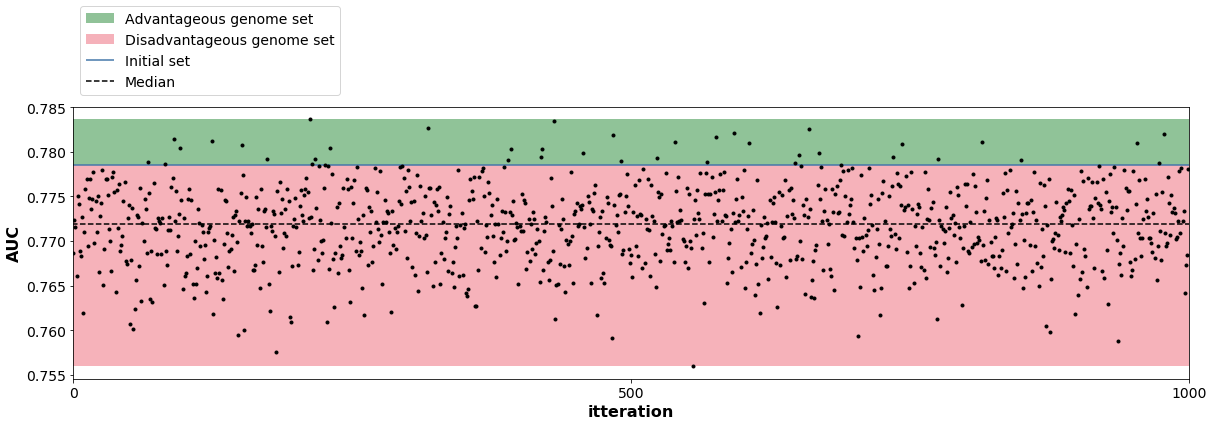

In [41]:
import statistics as s
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

y = use_1000_ran.loc[:,3]
print(len(y))
nulline = auc_base
median = s.median(use_1000_ran.loc[:,3])
plt.figure(figsize=(20,5))

plt.plot(y, color = "black", marker = "o", linestyle = "none", markersize=3)

#divergent_rem_list

plt.xlim(0, 999)
plt.xlabel("itteration", fontsize = 16, fontweight = "bold")
plt.ylabel("AUC", fontsize = 16, fontweight = "bold")
plt.xticks([0,500,1000], [0,500,1000], fontsize = 14)
plt.yticks(fontsize = 14)

#annotation lines
plt.hlines(nulline, xmin = -1, xmax = 1001, color = "#4477AA", label = "Initial set")
plt.hlines(median, xmin = -1, xmax = 1001, color = "black", linestyle = "--", label = "Median")

#annotation boxes
plt.axhspan(nulline, max(y), 0, 1, facecolor="#228833", alpha=0.5, label = "Advantageous genome set")
plt.axhspan(min(y), nulline, 0, 1, facecolor="#EE6677", alpha=0.5, label = "Disadvantageous genome set")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', prop = {"size": 14})
        
file_name = "proteome_random_1000_auc.pdf"
plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format = 'pdf',transparent = True)


In [42]:
#top and bottom worst performing sets
print(use_1000_ran)
sorted_1000_ran = use_1000_ran.iloc[1:,].sort_values(by = 3)
top_1000_ran = sorted_1000_ran[-50::]
bot_1000_ran = sorted_1000_ran[0:50]
top_bot_1000 = top_1000_ran.append(bot_1000_ran)

top_top1000 = sorted_1000_ran.iloc[-1,:].name.split(",")
bot_bot1000 = sorted_1000_ran.iloc[0,:].name.split(",")

print(len(top_1000_ran))
print(len(bot_1000_ran))
print(len(top_bot_1000))
print(top_top1000)
print(bot_bot1000)

                                                           3
0                                                           
CINT,TANN,SROS,ATRI,RALL,CCOR,PPER,CMER,CPAI,TM...  0.768610
MBRE,MONO,VBRA,SSAL,NGAD,SPLU,SMIN,OSAT,SKOW,AP...  0.772352
PBRA,CMIL,RBRE,SCOE,MNEG,RIRR,ADEA,RFIL,CCRI,TB...  0.771584
PINF,COWC,PHAL,CREI,SFAL,GTHE,ALAI,EHIS,TMEL,CM...  0.766082
MBRE,MONO,NGRU,PHUM,RIRR,NSPE,LGIG,YLIP,NGAD,TB...  0.774995
...                                                      ...
SCOE,ATHA,SROS,KFLA,IMUL,CGIG,SPAR,PTRI,DDIS,CR...  0.773362
MELO,PPER,CPAI,SMIM,TGON,CVEL,ADEA,SPUN,SPLU,PF...  0.764208
SMED,SKOW,ESIL,PABI,TADH,CMER,YLIP,PHUM,MBRE,CV...  0.767266
RFIL,AVAG,MELO,TADH,CSUB,SPUR,NNUC,EACE,PTRI,PA...  0.768472
EINV,BMOR,CINT,MCIR,TRUB,PHAL,AAST,SPUR,PHYT,GT...  0.778066

[1000 rows x 1 columns]
50
50
100
['EINV', 'OLUC', 'HAZT', 'IMUL', 'MDAP', 'BMOR', 'PCAU', 'APIS', 'PBLA', 'MNEG', 'PSPF', 'SAGG', 'MLAR', 'GTHE', 'TADH', 'PABI', 'CTEL', 'PERK', 'AGAM', 'ACOE', 'SPUR', 'CA

                                  good  bad  good_fraction
Vitrella brassicaformis CCMP3155     4   28       0.125000
Naegleria gruberi                    4   25       0.137931
Chromera velia  CCMP2878             5   29       0.147059
Basidiobolus meristosporus B9252     4   23       0.148148
Volvox carteri                       6   31       0.162162
...                                ...  ...            ...
Schistosoma mansoni                 21   10       0.677419
Taenia asiatica                     19    9       0.678571
Hyalella azteca                     15    7       0.681818
Trichinella spiralis                16    6       0.727273
Intoshia linei                      25    6       0.806452

[167 rows x 3 columns]


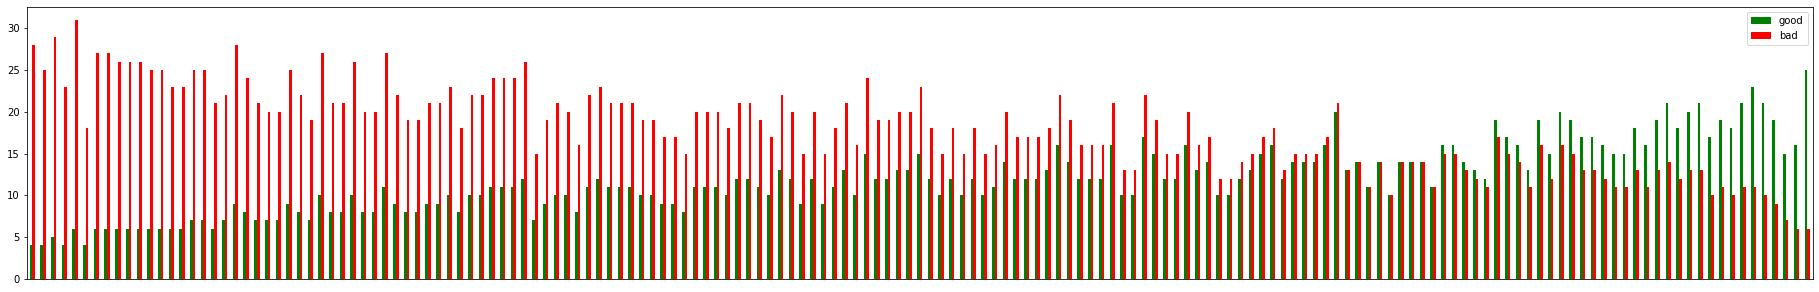

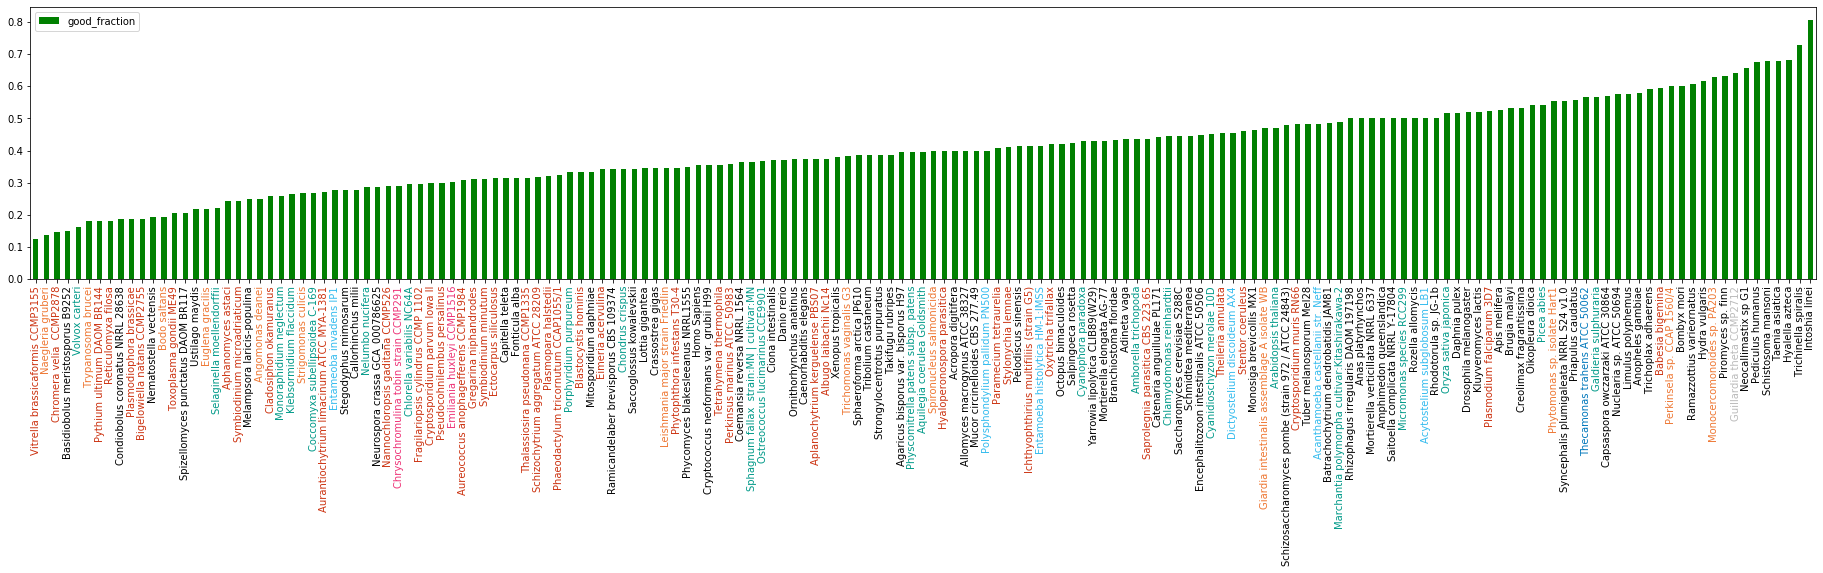

In [43]:
#### see how often species are in good or bad set
import matplotlib.pyplot as plt

#count how many times certain species are in a set that increases or decreases the auc values compared to base set
random_set_species_count = {}
#use_1000_ran.iloc[1:,]
#top and bottom worst performing sets
for index, row in top_bot_1000.iterrows():
    species_list = index.split(",")
    for species_id in species_list:
        if species_id not in random_set_species_count:
            random_set_species_count[species_id] = {"good":0, "bad":0}
            if row[3] > auc_base:
                random_set_species_count[species_id]["good"] = 1
            elif row[3] < auc_base:
                random_set_species_count[species_id]["bad"] = 1
        else:
            if row[3] > auc_base:
                random_set_species_count[species_id]["good"] += 1
            elif row[3] < auc_base:
                random_set_species_count[species_id]["bad"] += 1

#make dataframe
count_df_random_set = pd.DataFrame.from_dict(random_set_species_count, orient = 'index')
#count_df_random_set = count_df_random_set.reindex(leaves)
count_df_random_set["good_fraction"] = count_df_random_set["good"]/(count_df_random_set["good"]+count_df_random_set["bad"])
#sort on the fraction values
count_df_random_set.sort_values(['good_fraction'], inplace = True)


#plot the values
color_list = []
color_list += [color_supergrd[supergroup_d[x]] for x in count_df_random_set.index]
new_names = [species_names[x] for x in count_df_random_set.index]
count_df_random_set.index = new_names

print(count_df_random_set)

count_df_random_set.plot(y = ["good", "bad"], kind = "bar", stacked = False,\
          figsize=(32,5), color = ["green", "red"])
plt.xticks([])

count_df_random_set.plot(y = ["good_fraction"], kind = "bar", stacked = False,\
          figsize=(32,5), color = ["green"])


for i in range(0, len(plt.gca().get_xticklabels())):
    plt.gca().get_xticklabels()[i].set_color(color_list[i])

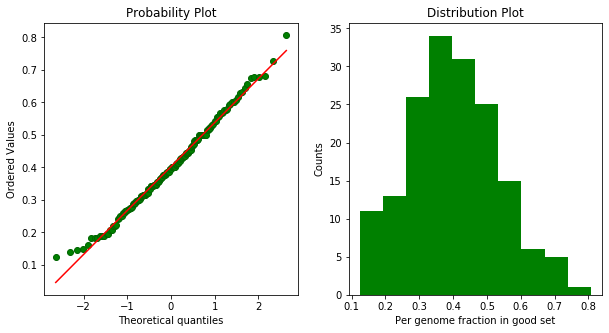

In [44]:
from scipy import stats as ss
import matplotlib.pyplot as plt
#probability of data following a normal distribution
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

gf = count_df_random_set["good_fraction"]
ss.probplot(gf, plot = ax)

ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_markeredgecolor('darkgreen')

ax2.hist(gf, color = "g")
plt.title("Distribution Plot")
plt.xlabel("Per genome fraction in good set")
plt.ylabel("Counts")
plt.show()
#right skewed with outliers to higher fractions if we use all 1000 random generated genome sets
#same if we pick the top and bottom 50 genome sets, only less outliers

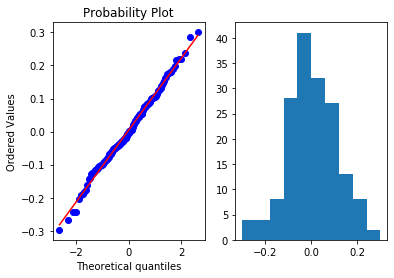

In [45]:
#just an example with selection of normal distributed data
from numpy import random
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 167)
fig = plt.figure()
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ss.probplot(s, plot = ax)
ax2.hist(s)
plt.show()

5000
max  41
min  20


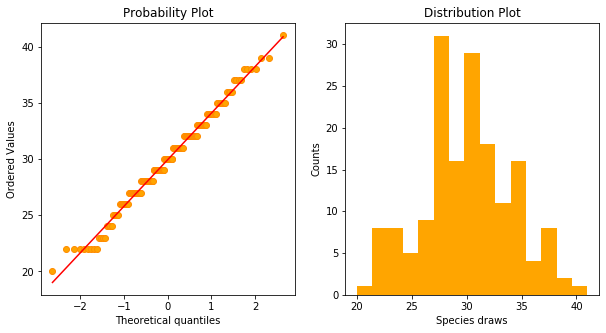

In [47]:
#s o to check if this deviation from normality
#is a result of the random draw and not biology/genomes
#look at the distribution of the species drawn
#should be normal distribution of random?

from scipy import stats as ss
import matplotlib.pyplot as plt
#probability of data following a normal distribution
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

total_draws = sum(count_df_random_set["good"]) + sum(count_df_random_set["bad"])
print(total_draws)
species_draws = (count_df_random_set["good"]\
                 + count_df_random_set["bad"]) 

print("max ", species_draws.max())
print("min ", species_draws.min())
ss.probplot(species_draws, plot = ax)

ax.get_lines()[0].set_markerfacecolor('orange')
ax.get_lines()[0].set_markeredgecolor('darkorange')

ax2.hist(species_draws, color = "orange", bins = 15)
plt.title("Distribution Plot")
plt.xlabel("Species draws")
plt.ylabel("Counts")
plt.show()



Text(0, 0.5, 'Fraction of species in good set')

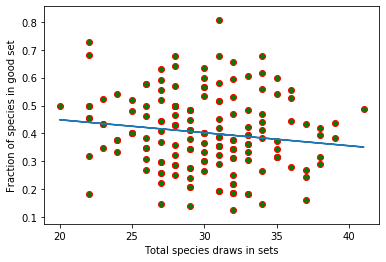

In [48]:
#see if the amount of times you are drawn is correlated with how much times
#you are in the bad or good set
x = count_df_random_set["good"] + count_df_random_set["bad"]
            
y = count_df_random_set["good_fraction"]

plt.scatter(x, y, edgecolors = "red", facecolors = "green")

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

plt.xlabel("Total species draws in sets")
plt.ylabel("Fraction of species in good set")

# Prediction accuracy by OG selection

In [55]:
#1000 x 63% of leca ogs for backdrop
#random data 1000 times random og sets
use_1000_ran_og = pd.read_csv("./auc_values_leca_og_random_use_final", delimiter = "\t", header = None, usecols = [2])

In [5]:
#Post LECA OGs
profile_post_leca = profile[~profile.index.isin(leca[0])] #not in leca
pos_set_post_leca = pos_set[~pos_set[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]
neg_set_post_leca = neg_set[~neg_set[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]

#for SCER
pos_set_post_leca_SCER = pos_set_SCER[~pos_set_SCER[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]
neg_set_post_leca_SCER = neg_set_SCER[~neg_set_SCER[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]

In [44]:
#!!!!!!!!!!!!RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
postleca_file = "./distance_sets/postLECA_set_dist"
all_species = profile_leca.columns
get_distance_set(profile_post_leca, all_species, pos_set_post_leca, neg_set_post_leca, postleca_file)

In [6]:
postleca_file = "./distance_sets/postLECA_set_dist"
fpr_postleca, tpr_postleca, auc_postleca = get_roc_auc(postleca_file)
print(auc_postleca)

0.691169180698398


In [46]:
#!!!!!!!!!!!!RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
allOGs_file = "./distance_sets/allOGs_set_dist"
all_species = profile.columns
get_distance_set(profile, all_species, pos_set, neg_set, allOGs_file)

In [7]:
allOGs_file = "./distance_sets/allOGs_set_dist"
fpr_allOGs, tpr_allOGs, auc_allOGs = get_roc_auc(allOGs_file)
print(auc_allOGs)

0.7342683562329857


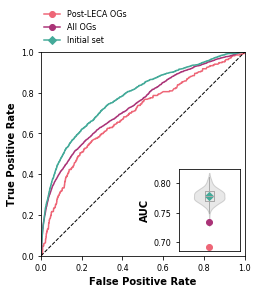

In [56]:

data_d = {"Post-LECA OGs": [fpr_postleca, tpr_postleca, auc_postleca],\
               "All OGs": [fpr_allOGs, tpr_allOGs, auc_allOGs],\
              "Initial set": [fpr_base, tpr_base, auc_base]}

#using the Tol color scheme
color = {"Post-LECA OGs": "#EE6677",\
         "All OGs": "#AA3377",\
        "Initial set": "#44AA99"}

marker = {"Post-LECA OGs": "o",\
             "All OGs": "o",\
             "Initial set": "D"}

fig_size = (0.5*max_width,0.5*max_width)
fig, ax = plt.subplots(figsize = fig_size)
plot_rocs(ax, data_d, color, marker, use_1000_ran_og[2])
#ax.text(-0.2, 1.3, "C.", ha="left", va="top", transform=ax.transAxes, weight='semibold', size = 12)
ax.set_aspect(1./ax.get_data_ratio())
fig.savefig("Figure4.pdf", bbox_inches = 'tight',pad_inches = 0)


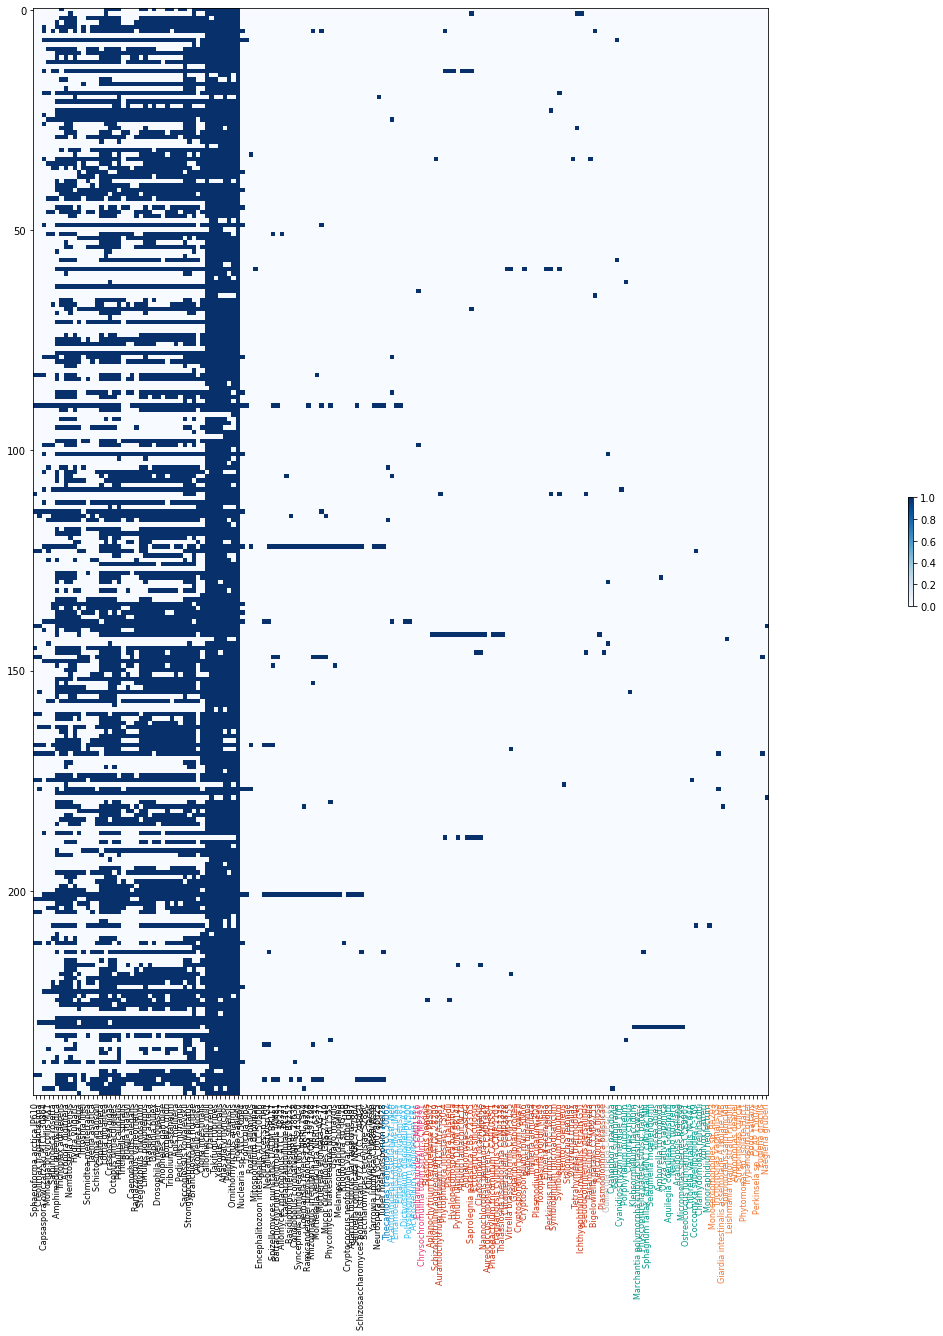

In [49]:
post_leca = pd.read_csv("./distance_sets/postLECA_set_dist")

unique_ogs_int = []
for i in range(len(post_leca[post_leca["set"] == 1].values)):
    unique_ogs_int += post_leca[post_leca["set"] == 1]["OG_A,OG_B"][i].strip("()").replace("'", "").split(", ")
unique_ogs_int = list(set(unique_ogs_int)) #get unique ogs by making it a set and a list for better workability

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize = (50, 20))

g = ax.imshow(profile_post_leca.loc[unique_ogs_int,leaves], cmap = "Blues")

ax.set_xticks(range(167))
#ax.set_yticks(range(167))
ax.set_xticklabels([species_names[x] for x in leaves], rotation = 90, size = 8)
#ax.set_yticklabels([species_names[x] for x in list(good_set_compare_ordered.index)])



for i in range(0, len(plt.gca().get_xticklabels())):
    plt.gca().get_xticklabels()[i].set_color(color_list[i])
fig.colorbar(g, shrink = 0.1, cmap = "Blues")

14237 77029 91266
[1191, 462, 1741]
0
1    160
2    159
3     55
4    167
7    154
dtype: int64


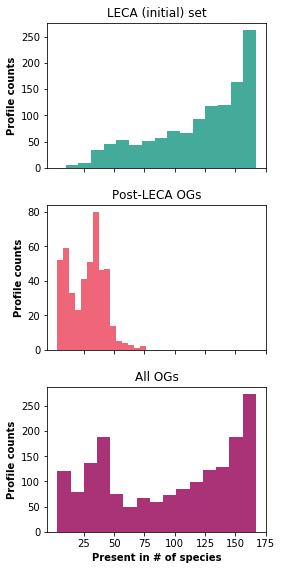

In [57]:
#Ogs present in x species
import seaborn as sns
fig, ax = plt.subplots(3,1, figsize = (4,8), sharex = True)


print(len(profile_leca), len(profile_post_leca), len(profile))

data_list1 = [profile_leca, profile_post_leca, profile]
int_sets = [pos_set_leca, pos_set_post_leca, pos_set]
data_list = []

for i in range(len(data_list1)):
    set_int = list(set(list(int_sets[i]["OG_A"]) + list(int_sets[i]["OG_B"])))
    data_list += [data_list1[i][data_list1[i].index.isin(set_int)]]
            
print([len(x) for x in data_list])

data_summed = [data_df.sum(axis = 1) for data_df in data_list]
print(data_summed[0].head())

#nums = ["I.", "II.", "III."]
color = ["#44AA99", "#EE6677", "#AA3377"]
names = ["LECA (initial) set", "Post-LECA OGs", "All OGs"]

for i in range(3):
    axi = ax[i]
    data = data_summed[i]
    #sh = sns.histplot(data_summed[i], legend = False,ax = axi, color = color[i])
    axi.hist(data[data>2], color = color[i], bins = 15)
    #sh.text(0.02, 0.98, nums[i], ha="left", va="top", transform=axi.transAxes, weight='semibold')
    axi.set_title(names[i])
    axi.set_ylabel("Profile counts", fontweight = "bold")
    axi.set_xticks([25,50,75,100,125,150,175])
ax[2].set_xlabel("Present in # of species", fontweight = "bold")

fig.tight_layout(pad=1, h_pad = 1.5)

# Prediction accuracy by interactome selection
1. Parsing biogrid on 5 pubID or as is & negative set on 5 interactions or not
2. Using Human vs. yeast set

In [58]:
####get interaction set from biogrid not parsed on 5 pubIDs
####get biogrid not parsed on 5 pubIDs and the negative set not parsed on 5 interactions
positive_file = "Sonicparanoid_sensitive_biogrid_all"
pos_setr_all = pd.read_csv(positive_file, sep = "\t")
pos_set_all = pos_setr_all[["OG_A", "OG_B"]]
pos_set_all_leca = pos_set_all[pos_set_all[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]
print(len(pos_set_all_leca))
all_species = list(profile_leca.columns)
pos_set_leca.head()

negative_file = "Sonicparanoid_sensitive_pseudo_neg_all"
neg_setr_all = pd.read_csv(negative_file, sep = "\t", header = None)
neg_set_all = neg_setr_all[[2,3]]
neg_set_all.columns = [["OG_A", "OG_B"]]
neg_set_all_leca = neg_set_all[neg_set_all[["OG_A", "OG_B"]].isin(list(leca[0])).all(axis=1)]
print(len(neg_set_all_leca))

172282


/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


13420148


In [54]:
#RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
#All interactions and not filtered on 5 pubID, including negative set with at least 5 in
all_pos_file = "./distance_sets/all_pos_interactions_dist"
all_species = profile_leca.columns
get_distance_set(profile_leca, all_species, pos_set_all_leca, neg_set_leca, all_pos_file)

In [59]:
all_pos_file = "./distance_sets/all_pos_interactions_dist"
fpr_all_pos_int, tpr_all_pos_int, auc_all_pos_int = get_roc_auc(all_pos_file)
print(auc_all_pos_int)

0.6378843278328883


In [58]:
#RUN ONCE TO CALCULATE DISTANCES AND AUTOPUT TO FILE, TAKES TIME
#SCER interactome bioGRID
SCER_int_file = "./distance_sets/SCER_interactions_dist"
all_species = profile_leca.columns
get_distance_set(profile_leca, all_species, pos_set_leca_SCER, neg_set_leca_SCER, SCER_int_file)

In [60]:
SCER_int_file = "./distance_sets/SCER_interactions_dist"
fpr_SCER_int, tpr_SCER_int, auc_SCER_int = get_roc_auc(SCER_int_file)
print(auc_SCER_int)

0.7126229659694671


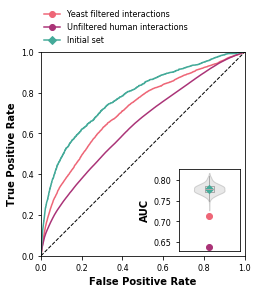

In [61]:
data_d = {"Yeast filtered interactions": [fpr_SCER_int, tpr_SCER_int, auc_SCER_int],\
            "Unfiltered human interactions": [fpr_all_pos_int, tpr_all_pos_int, auc_all_pos_int],\
            "Initial set": [fpr_base, tpr_base, auc_base]}

#using the Tol color scheme
color = {"Yeast filtered interactions": "#EE6677",\
         "Unfiltered human interactions": "#AA3377",\
        "Initial set": "#44AA99"}

marker = {"Yeast filtered interactions": "o",\
          "Unfiltered human interactions": "o",\
          "Initial set": "D"}

fig_size = (0.5*max_width,0.5*max_width)
fig, ax = plt.subplots(figsize = fig_size)
plot_rocs(ax, data_d, color, marker, use_1000_ran_og[2])
#ax.text(-0.2, 1.3, "C.", ha="left", va="top", transform=ax.transAxes, weight='semibold', size = 12)
ax.set_aspect(1./ax.get_data_ratio())
fig.savefig("Figure5A.pdf", bbox_inches = 'tight',pad_inches = 0)

# Understand better why auc changes

In [22]:
### how many interaction pairs are shared with human in total
int_dict_compared = {}
for idx in range(0, len(pos_set_leca)):
    #positive interactions leca human
    OG_A = pos_set_leca.iloc[idx, 0]
    OG_B = pos_set_leca.iloc[idx, 1]
    if OG_A in profile_leca.index and OG_B in profile_leca.index:
        if OG_A != OG_B:
            if (OG_A, OG_B) not in int_dict_compared:
                    if (OG_B, OG_A) not in int_dict_compared:
                        #get profiles for interacting OGs
                        profA = profile_leca.loc[OG_A,]
                        profB = profile_leca.loc[OG_B,]
                        sums = [el1 + el2 for (el1, el2) in zip(profA, profB)]
                        int_dict_compared[(OG_A, OG_B)] = sums

In [23]:
#make dataframe from dict
sums = pd.DataFrame.from_dict(int_dict_compared, orient = "index")
sums.columns = profile_leca.columns
#count per species
count_ints_species = {}
for species in profile_leca.columns:
    col = list(sums.loc[:,species].values)

    count_ints_species[species] = {"co-absence-all": col.count(0), "illogical-absence-all": col.count(1),\
                                  "present-all": col.count(2)}
print(len(count_ints_species))
sums_df = pd.DataFrame.from_dict(count_ints_species, orient = "index") #as example
print(sums_df.reindex(leaves))

167
      co-absence-all  illogical-absence-all  present-all
SARC              75                    442         1264
CFRA              47                    310         1424
COWC              39                    277         1465
MBRE              92                    494         1195
SROS              42                    395         1344
...              ...                    ...          ...
TBRU             392                    655          734
BSAL             341                    675          765
PERK             670                    583          528
EGRA             171                    662          948
NGRU             104                    533         1144

[167 rows x 3 columns]


In [174]:
### amount of OGs shared with species
def species_shared_ogs(profile_leca, species):
    OGs = profile_leca[profile_leca[species] == 1]
    OGs_s = OGs.sum()
    return OGs_s

In [175]:
from sklearn.metrics import pairwise_distances
#Final table species and info
random_rem = pd.read_csv("auc_values_proteome_removal", delimiter = "\t", header = None, index_col = 0,usecols = [0,1])
all_corr = profile_leca.corr(method='pearson')

dist_df_HSAP = pd.DataFrame(pairwise_distances(profile_leca.T, metric = 'cosine'), index = profile_leca.columns, columns = profile_leca.columns)["HSAP"]
print(dist_df_HSAP)
OGs_HSAP_s = species_shared_ogs(profile_leca, "HSAP")

df_s = pd.DataFrame(count_dict_species_HSAP).T
df_s = df_s.astype(float)
df_s["normalized illogical"] = df_s["illogical-absence"] / (df_s["illogical-absence"] + df_s["co-absence"])
#print(df_s.head()) #/ 416

final_df = pd.DataFrame(df_s)

final_df = final_df.join(OGs_HSAP_s.rename("OGs shared with HSAP"))

#leca retained OGs per species
leca_ogs = pd.DataFrame(len(profile_leca) - profile_leca.sum())
leca_ogs.columns = ["leca loss"]


final_df = final_df.join([leca_ogs]) #["species-found"]
#final_df = final_df.join(all_corr.loc["HSAP",][leaves])
final_df = final_df.join(dist_df_HSAP.rename("Cosine distance to HSAP"))

random_rem.columns = ["auc when removed"]
final_df = final_df.join(random_rem - auc_base) #difference in auc from base
final_df = final_df.join(species_loss["species_loss"].rename("species loss"))
final_df = final_df.join(species_loss["clade_loss"].rename("clade loss"))
#species_df2.index.name = "Species_id"
#final_df = final_df.loc[leaves]
#species_df2 = species_df2.join(species_df[['Species_name','supergroup', 'order', 'phylum', 'kingdom']])

#print(random_rem)

final_df_all = final_df.join(species_absences["Busco_absences"].rename("BUSCO absences")).join(species_df)
final_df_all.to_csv("species_measures.csv",float_format='%f')
#print(final_df.head())
final_df.columns

AANO    0.445448
AAST    0.298043
ABIS    0.353985
ACAS    0.347604
ACOE    0.327697
          ...   
UMAY    0.346521
VBRA    0.340585
VCAR    0.330675
XTRO    0.047641
YLIP    0.342214
Name: HSAP, Length: 167, dtype: float64


Index(['co-absence', 'illogical-absence', 'present', 'normalized illogical',
       'OGs shared with HSAP', 'leca loss', 'Cosine distance to HSAP',
       'auc when removed', 'species loss', 'clade loss'],
      dtype='object')

/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


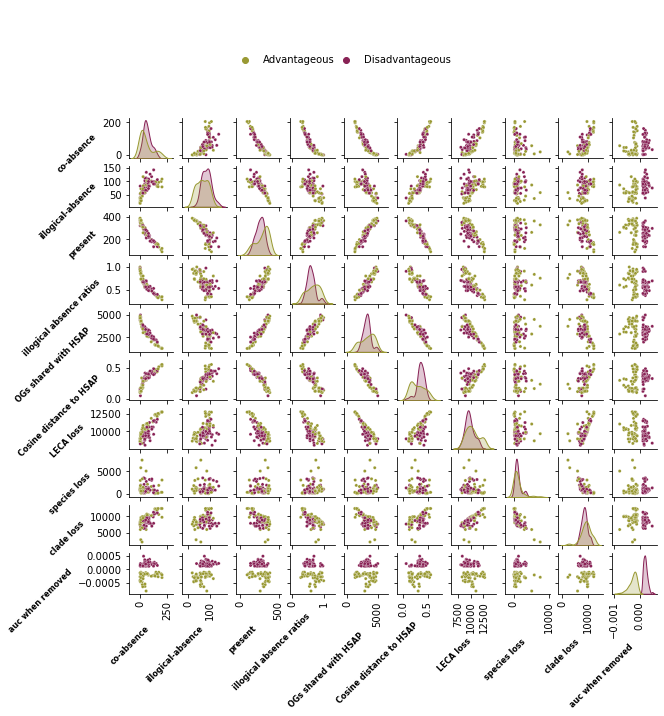

In [26]:
import seaborn as sns
#large parisplot


#rest_genomes = [x for x in list(final_df.index) if x not in list(best.index) + list(worst.index)]
best_worst_df = pd.DataFrame({"set": ["Advantageous"]*50 + ["Disadvantageous"]*50}, index = list(best.index) + list(worst.index))

best_worst_df = final_df.join(best_worst_df)
#order the labels how they need to go in the figure
labels =['co-absence', 'illogical-absence', 'present', 'normalized illogical',\
       'OGs shared with HSAP', 'Cosine distance to HSAP', 'leca loss',\
       'species loss', 'clade loss', 'auc when removed',"set"]
ordered = best_worst_df[labels]

rename_labels = ['co-absence', 'illogical-absence', 'present', 'illogical absence ratios',\
       'OGs shared with HSAP', 'Cosine distance to HSAP', 'LECA loss',\
       'species loss', 'clade loss', 'auc when removed',"set"]

ordered.columns = rename_labels

size_fig = (max_height)/(len(labels)-1) #size of individual pair plots

grouping_on = "set" #what to color the groups
g = sns.pairplot(ordered, hue = grouping_on, palette = ['#999933', '#882255'],\
                 hue_order = ["Advantageous", "Disadvantageous"],\
                 height = size_fig, aspect = 1,\
                plot_kws={"s":10})#palette = ["green", "red"]
#make more visible for small values of the auc
g.axes[9,0].set_ylim((min(ordered["auc when removed"])-0.0001, max(ordered["auc when removed"]+0.0001)))

#legend location
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove() #remove default because we cannot change it properly in seaborn pairplot
g.fig.legend(handles=handles, labels=labels, ncol=2,\
             columnspacing = 0.1,bbox_to_anchor=(0.3, 1.02, 1., .102),\
             loc='lower left', frameon = False)
#g._legend.set_bbox_to_anchor((0.5, 0.7))

#get the right layout for axes
for ax in g.axes.flatten():
    # x axis labels 
    ax.set_xlabel(ax.get_xlabel(), rotation = 45, fontweight = "bold", fontsize = 8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    # y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 45, fontweight = "bold", fontsize = 8)
    #ax.set_yticklabels(ax.get_yticklabels(), fontsize = 6)
    # set labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')
    ax.xaxis.get_label().set_horizontalalignment('right')

g.savefig("SupplementaryFig5A.pdf", bbox_inches = 'tight',pad_inches = 0)

Index(['co-absence', 'illogical-absence', 'present', 'normalized illogical',
       'OGs shared with HSAP', 'leca loss', 'Cosine distance to HSAP',
       'auc when removed', 'species loss', 'clade loss'],
      dtype='object')
      Illogical \n absence ratios  Present \n interactions  \
ABIS                     0.597015                    270.0   
ADIG                     1.000000                    365.0   
AGAM                     0.736842                    366.0   
APIS                     0.862069                    375.0   
AQUE                     0.837209                    361.0   
...                           ...                      ...   
TGON                     0.416667                    188.0   
TPSE                     0.556180                    226.0   
UMAY                     0.507692                    274.0   
VBRA                     0.480263                    252.0   
VCAR                     0.563025                    285.0   

      Cosine distance \n to

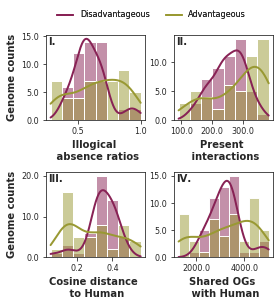

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
print(final_df.columns)
labels = ["normalized illogical", "present", "Cosine distance to HSAP", "OGs shared with HSAP", "set"]
best_worst_df = pd.DataFrame({"set": ["Advantageous"]*50 + ["Disadvantageous"]*50}, index = list(best.index) + list(worst.index))
best_worst_df = final_df.join(best_worst_df)

retrieve = best_worst_df[labels]

rb = retrieve[retrieve["set"] == "Advantageous"]
rw = retrieve[retrieve["set"] == "Disadvantageous"]

rs = rb.append(rw)

rs.columns = ["Illogical \n absence ratios","Present \n interactions",\
              "Cosine distance \n to Human", "Shared OGs \n with Human",\
               "set"]
print(rs)

fig, ax = plt.subplots(2,2, figsize = (0.5*max_width,0.5*max_width))
sns.set_style(style='white') #turn off grid
sns.set_style(style='ticks') #with tick marks

colors = ['#999933','#882255']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

i = 0

i_x = [0,0,1,1]
j_x = [0,1,0,1]

names = ["I.", "II.", "III.", "IV."]
for col in rs.columns[:-1]:
    axi = ax[i_x[i],j_x[i]]
    sh = sns.histplot(data = rs, x = col, hue = "set", legend = False,\
             kde=True, line_kws={'linewidth': 2}, common_bins = True, ax = axi)

    sh.text(0.02, 0.98, names[i], ha="left", va="top", transform=axi.transAxes, weight='semibold')
    #, legend = True,label = ["Advantageous", "Disadvantageous"],
    axi.set_xlabel(col, size=10, fontweight = "bold")
    axi.set_yticklabels(sh.get_yticks(), size = 8)
    axi.set_xticklabels(sh.get_xticks(), size = 8)
    if i in [0,2]:
        axi.set_ylabel("Genome counts", size=10, fontweight = "bold")
    else:
        axi.set_ylabel(None)
    i += 1

fig.tight_layout(pad=0.2, h_pad = 1)

#be carefull, coloring done by hand
leg1 = plt.legend(bbox_to_anchor=(-1.25, 2.7, 1, 0), loc='lower left', prop = {"size": 8},
                 labels = ["Disadvantageous", "Advantageous"], frameon = False, ncol = 2)
fig.add_artist(leg1)


#axi.set_yticklabels(sh.get_yticks(), size = 10)
#axi.set_xticklabels(sh.get_xticks(), size = 10)
#axi.set_ylabel("Counts", size=14, fontweight = "bold")
#axi.set_xlabel("Interactions present", size=14, fontweight = "bold")
#sh.legend_.set_title(None)
#sh.legend(bbox_to_anchor=(0.01, 1.2, 0.5, 0.2), loc='upper left')
fig.savefig("Figure3C.pdf", bbox_inches = 'tight',pad_inches = 0)

In [53]:
from sklearn.metrics import pairwise_distances
#Final table species and info
#random_rem = pd.read_csv("auc_values_proteome_removal", delimiter = "\t", header = None, index_col = 0,usecols = [0,1])
all_corr = profile_leca.corr(method='pearson')

dist_df_SCER = pd.DataFrame(pairwise_distances(profile_leca.T, metric = 'cosine'), index = profile_leca.columns, columns = profile_leca.columns)["HSAP"]
print(dist_df_SCER)
OGs_SCER_s = species_shared_ogs(profile_leca, "SCER")

df_s = pd.DataFrame(count_dict_species_SCER).T
df_s = df_s.astype(float)
df_s["normalized illogical"] = df_s["illogical-absence"] / (df_s["illogical-absence"] + df_s["co-absence"])
#print(df_s.head()) #/ 416

final_df = pd.DataFrame(df_s)

final_df = final_df.join(OGs_SCER_s.rename("OGs shared with SCER"))

#leca retained OGs per species
leca_ogs = pd.DataFrame(len(profile_leca) - profile_leca.sum())
leca_ogs.columns = ["leca loss"]


final_df = final_df.join([leca_ogs])

final_df = final_df.join(dist_df_SCER.rename("Cosine distance to SCER"))

random_rem_SCER.columns = ["auc when removed"]
final_df = final_df.join(random_rem_SCER - auc_base) #difference in auc from base
final_df = final_df.join(species_loss["species_loss"].rename("species loss"))
final_df = final_df.join(species_loss["clade_loss"].rename("clade loss"))
#species_df2.index.name = "Species_id"
#final_df = final_df.loc[leaves]
#species_df2 = species_df2.join(species_df[['Species_name','supergroup', 'order', 'phylum', 'kingdom']])

#print(random_rem)

#final_df_all = final_df.join(species_absences["Busco_absences"].rename("BUSCO absences")).join(species_df)
#final_df_all.to_csv("species_measures.csv",float_format='%f')
#print(final_df.head())
final_df.columns

AANO    0.445448
AAST    0.298043
ABIS    0.353985
ACAS    0.347604
ACOE    0.327697
          ...   
UMAY    0.346521
VBRA    0.340585
VCAR    0.330675
XTRO    0.047641
YLIP    0.342214
Name: HSAP, Length: 167, dtype: float64


NameError: name 'random_rem_SCER' is not defined

In [40]:
best_worst_df = pd.DataFrame({"set": ["best"]*50 + ["worst"]*50}, index = list(best_SCER.index) + list(worst_SCER.index))
final_df_SCER = final_df.join(best_worst_df)
labels = ["set", "leca loss", "OGs shared with SCER",\
          "co-absence", "illogical-absence", "present","Cosine distance to SCER", "auc when removed"]
retrieve = final_df_SCER[labels]
#retrieve = species_df3.loc[list(best.index) + list(worst.index),]

grouping_on = "set" #what to color the groups
g = sns.pairplot(retrieve, hue = grouping_on, palette = ['#882255', '#999933'])#, palette = ["red", "green"]
g.axes[6,0].set_ylim((min(retrieve["auc when removed"]),max(retrieve["auc when removed"])))

#file_name = "pair_plots_stats_best_worst_SCER_supergroup.pdf"
#plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format = 'pdf',transparent = True)



NameError: name 'best_SCER' is not defined

#### GO analysis yeast vs. human leca interactions

See if there is an enrichment in human vs. yeast interactions. Hypothesis is that multiple ancestral complexes have been lost in yeast. 

In [193]:
import os

#Read in all foreground and background sets
genes_foreground = {}
genes_background = {}
gene_sets = {}


dir_go = "GO_analysis"
for filename in os.listdir(dir_go):
    if filename.startswith("H"):
        file_dir = dir_go + "/" + filename
        set_num = int(filename.split("_")[-1]) 

        if "foreground" in filename:
            genes_foreground[set_num] = pd.read_csv(file_dir, sep = "\t", index_col = 0, header = None)
        elif "background" in filename:
            genes_background[set_num] = pd.read_csv(file_dir, sep = "\t", index_col = 0, header = None)

In [194]:
go_file = "../Data/mart_export_human_ensemble102_GO_15012021.txt"
go_df = pd.read_csv(go_file, sep = "\t")
#filter out genes with nog GO term
go_df = go_df[~go_df["GO term accession"].isna()]
print(len(go_df))

#drop non unique go-gene pairs
go_df = go_df.drop_duplicates(subset = ["Gene stable ID", "GO term accession"], keep = "last").set_index("Gene stable ID")
print(len(go_df))

#go_df[go_df["GO term evidence code"] == "ND"]
go_df.head()

1317989
402469


,Gene name,Gene description,GO term accession,GO term name,GO term definition,GO term evidence code,GO domain
Gene stable ID,,,,,,,
ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...,GO:0016020,membrane,A lipid bilayer along with all the proteins an...,IEA,cellular_component
ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...,GO:0055114,oxidation-reduction process,A metabolic process that results in the remova...,IEA,biological_process
ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...,GO:0016021,integral component of membrane,The component of a membrane consisting of the ...,IEA,cellular_component
ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...,GO:0005739,mitochondrion,"A semiautonomous, self replicating organelle t...",IEA,cellular_component
ENSG00000198888,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...,GO:0005515,protein binding,Interacting selectively and non-covalently wit...,IPI,molecular_function


In [195]:
for set_num in genes_background:
    gene_sets[set_num] = {"foreground": list(genes_foreground[set_num].index), "background": list(genes_background[set_num].index)}

In [196]:
print(gene_sets[1]["foreground"][0:10])

['ENSG00000198001', 'ENSG00000064726', 'ENSG00000150455', 'ENSG00000110906', 'ENSG00000120868', 'ENSG00000108468', 'ENSG00000126214', 'ENSG00000103319', 'ENSG00000070423', 'ENSG00000126562']


In [197]:
import scipy.stats as s

##q, number of genes in selected set with certain GO term (foreground)
##m, total number of genes with certain GO term (foreground + background)
##n (N - m), total number of genes without that GO term (total nunber of genes - m)
##k, total number of genes in the selected set 


## phyper(q,m,n,k,lower.tail = F))

##scipy contvention for parameters
## M = population size
## n = number of successes
## N = sample size
## X is draw succes

## Translate to hypergeom.sf x = q, M = n+m. n = m, N = k
## becomes hypergeom.sf(q-1,n+m,m,k)? 
##########################################

def go_enrich(foreground_genes, background_genes, go_meta, onthology):
    #df_enrichment
    d_enrichment = {}
    ##ontology is one of : biological_process, cellular_component, molecular_function
    ## filter on onthology
    go_terms = go_meta[go_meta["GO domain"] == onthology]
    #All genes in foreground set and Go terms
    go_foreground = go_terms[go_terms.index.isin(foreground_genes)]
    go_background = go_terms[go_terms.index.isin(background_genes)]
    go_background = go_background.append(go_foreground)

    ## count table of forground set genes for every GO term (GOx : #) --> q
    q = go_foreground["GO term accession"].value_counts()
    ## count table of background set (total set?) of genes for every GO term (GOx: #) --> m
    m = go_background["GO term accession"].value_counts()
    ## length (genes in) background (total set?) - counts of background (total set?) m --> n
    n = len(go_background.index.value_counts())
    ## length (genes in) foreground set ---> k
    k = len(go_foreground.index.value_counts())
    
    for GO in q.index:
        go_p = s.hypergeom.sf(q[GO]-1,n,k, m[GO])
        #print(q[annotation], m[annotation], n, k)
        go_enrich = (q[GO]/k) / (m[GO]/n)

        # Enrichment does not work well for small overlaps, so we filter for a minimun overlap of 3
        # and signif output$SetGO > 2 & output$pval < 0.05
        if go_p < 0.01 and n > 2: # and go_enrich > 1
            #print(go_terms[go_terms["GO term accession"] == annotation][["GO term name", "GO term definition"]])
            annot_go = go_terms[go_terms["GO term accession"] == GO]
            genes_enrich = annot_go.index
            
            name_gene = annot_go["Gene name"]
            gene_descript = annot_go["Gene description"]
            
            gene_n_d = [str(x) + ": " + str(y) for x,y in zip(name_gene, gene_descript)]
            #print(gene_n_d)
            GO_name = annot_go["GO term name"][0]
            GO_descript = annot_go["GO term definition"][0]

            if GO not in d_enrichment:
                d_enrichment[GO] = {"GO name": GO_name, "GO description": GO_descript,\
                                    "p-value": go_p, "Enrichment":go_enrich,\
                                    "Gene list": gene_n_d, "Gene counts": len(gene_n_d),\
                                    "label": GO_name + " (" + GO + ")", "Onthology": onthology}
    return pd.DataFrame.from_dict(d_enrichment, orient = "index") #d_enrichment#pd.DataFrame.from_dict(d_enrichment, orient = "index")

enrich_d = {}
processes = ["biological_process", "cellular_component", "molecular_function"]

for set_num in gene_sets.keys():
    
    print(set_num)
    for component in processes:
        if set_num not in enrich_d:
            enrich_d[set_num] = {}
            enrich_d[set_num][component] = go_enrich(gene_sets[set_num]["foreground"], gene_sets[set_num]["background"], go_df, component)
        else: 
            enrich_d[set_num][component] = go_enrich(gene_sets[set_num]["foreground"], gene_sets[set_num]["background"], go_df, component)

            #print(enrich_d[9]["biological_process"].sort_values(by = "Enrichment", ascending = False))


9
1
4
2
3
5
10
6
7
8


In [198]:
import scipy.stats as s

##q, number of genes in selected set with certain GO term (foreground)
##m, total number of genes with certain GO term (foreground + background)
##n (N - m), total number of genes without that GO term (total nunber of genes - m)
##k, total number of genes in the selected set 


## phyper(q,m,n,k,lower.tail = F))

##scipy contvention for parameters
## M = population size
## n = number of successes
## N = sample size
## X is draw succes

## Translate to hypergeom.sf x = q, M = n+m. n = m, N = k
## becomes hypergeom.sf(q-1,n+m,m,k)? 
##########################################

def go_enrich(foreground_genes, background_genes, go_meta, onthology, set_num):
    #df_enrichment
    d_enrichment = {}
    ##ontology is one of : biological_process, cellular_component, molecular_function
    ## filter on onthology
    go_terms = go_meta[go_meta["GO domain"] == onthology]
    #All genes in foreground set and Go terms
    go_foreground = go_terms[go_terms.index.isin(foreground_genes)]
    go_background = go_terms[go_terms.index.isin(background_genes)]
    go_background = go_background.append(go_foreground)

    ## count table of forground set genes for every GO term (GOx : #) --> q
    q = go_foreground["GO term accession"].value_counts()
    ## count table of background set (total set?) of genes for every GO term (GOx: #) --> m
    m = go_background["GO term accession"].value_counts()
    ## length (genes in) background (total set?) - counts of background (total set?) m --> n
    n = len(go_background.index.value_counts())
    ## length (genes in) foreground set ---> k
    k = len(go_foreground.index.value_counts())
    
    columns = ["GO", "GO name", "GO description","p-value", "Enrichment", "Gene counts",\
                                 "Onthology","set_num", "Gene list"]
    df = pd.DataFrame(columns = columns)
    
    for GO in q.index:
        go_p = s.hypergeom.sf(q[GO]-1,n,k, m[GO])
        #print(q[annotation], m[annotation], n, k)
        go_enrich = (q[GO]/k) / (m[GO]/n)

        # Enrichment does not work well for small overlaps, so we filter for a minimun overlap of 3
        # and signif output$SetGO > 2 & output$pval < 0.05
        if go_p < 0.01 and n > 2: # and go_enrich > 1
            #print(go_terms[go_terms["GO term accession"] == annotation][["GO term name", "GO term definition"]])
            annot_go = go_terms[go_terms["GO term accession"] == GO]
            genes_enrich = annot_go.index
            
            name_gene = annot_go["Gene name"]
            gene_descript = annot_go["Gene description"]
            
            gene_n_d = [str(x) + ": " + str(y) for x,y in zip(name_gene, gene_descript)]
            #print(gene_n_d)
            GO_name = annot_go["GO term name"][0]
            GO_descript = annot_go["GO term definition"][0]

            #if GO not in d_enrichment:
            df = df.append(pd.DataFrame([[GO, GO_name, GO_descript, go_p, go_enrich,\
                                         len(gene_n_d), onthology, set_num, gene_n_d,]], columns = columns), ignore_index = True)#pd.DataFrame
                
    return df #d_enrichment#pd.DataFrame.from_dict(d_enrichment, orient = "index")

processes = ["biological_process", "cellular_component", "molecular_function"]
columns = ["GO", "GO name", "GO description","p-value", "Enrichment", "Gene counts",\
                                 "Onthology","set_num","Gene list"]
enrichment_df = pd.DataFrame(columns = columns)

for set_num in gene_sets.keys():
    for component in processes:
            enrichment_df = enrichment_df.append(go_enrich(gene_sets[set_num]["foreground"], gene_sets[set_num]["background"], go_df, component, set_num))

            
enrichment_df.reset_index(inplace = True, drop = True)
print(enrichment_df)

#write enrichment out to respective sets to have the tables with genes. 
file = "./GO_analysis/GO_enrichment_all.tsv"
enrichment_df.to_csv(file, header=True, sep = "\t")


#print(enrich_d[9]["biological_process"].sort_values(by = "Enrichment", ascending = False))

             GO                                            GO name  \
0    GO:0016567                             protein ubiquitination   
1    GO:0000122  negative regulation of transcription by RNA po...   
2    GO:0006915                                  apoptotic process   
3    GO:0043065           positive regulation of apoptotic process   
4    GO:0042127        regulation of cell population proliferation   
..          ...                                                ...   
198  GO:0004842             ubiquitin-protein transferase activity   
199  GO:0061630                  ubiquitin protein ligase activity   
200  GO:0008137           NADH dehydrogenase (ubiquinone) activity   
201  GO:0003954                        NADH dehydrogenase activity   
202  GO:0016651         oxidoreductase activity, acting on NAD(P)H   

                                        GO description   p-value  Enrichment  \
0    The process in which one or more ubiquitin gro...  0.001565    1.328464   

/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/eva/eva2/Programs/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


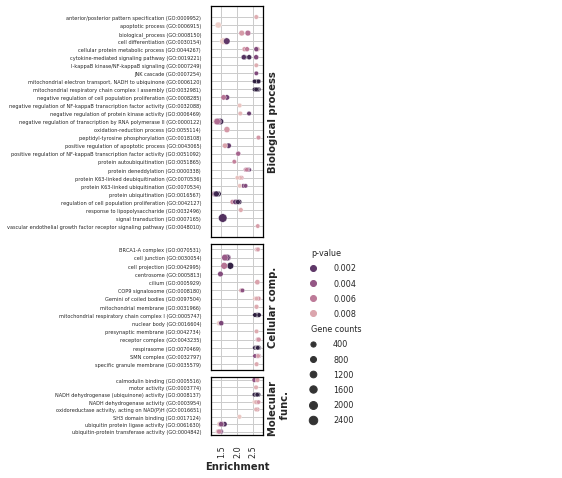

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.edgecolor': "black"})
enrichment_df["labels"] = enrichment_df["GO name"] +" (" + enrichment_df["GO"]+ ")" 
                        
enrichment_df_sorted = enrichment_df.loc[enrichment_df["labels"].str.lower().sort_values().index]

#reverse color palette to give lower p-values darker colour
rp = sns.relplot(data = enrichment_df_sorted, y = "labels", x = "Enrichment",row = "Onthology",\
           hue = "p-value", palette = sns.cubehelix_palette(as_cmap=True, reverse = True), size = "Gene counts",height = 0.3*max_height,aspect = 0.4,\
           facet_kws={'sharey': False, 'sharex': True, "despine": False,\
                     "gridspec_kws": {"hspace":0.05, 'height_ratios': [2,1.1,0.5]}})
axes = rp.axes.flatten()

process_list = ["Biological process", "Cellular comp.", "Molecular \n func."]
for i in range(3):
    axes[i].set_title("",)
    axes[i].yaxis.set_label_position("right")
    #axes[i].yaxis.tick_right()
    axes[i].set_ylabel(process_list[i], rotation = 90, labelpad = 5, size = 10, fontweight = "bold")
    axes[i].set_yticklabels(axes[i].get_yticklabels(), size = 5)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), size = 8, rotation = 90)

plt.xlabel("Enrichment", fontweight = "bold", size = 10)

leg = rp._legend
leg.set_bbox_to_anchor([2.2, 0.25])
plt.setp(rp._legend.get_texts(), fontsize=8)
#ax.grid(axis = 'x', which='major')
#ax.grid(axis = 'y', which ='major')
#plt.rcParams['figure.figsize']=(0.4*max_height,max_width)

rp.savefig("Figure5B.pdf", bbox_inches = 'tight',pad_inches = 0)

In [79]:
enrichment_df.head()

,GO,GO name,GO description,p-value,Enrichment,Gene counts,Onthology,set_num,Gene list,labels
0,GO:0016567,protein ubiquitination,The process in which one or more ubiquitin gro...,0.001565,1.328464,700,biological_process,9,[TRIM27: tripartite motif containing 27 [Sourc...,protein ubiquitination (GO:0016567)
1,GO:0000122,negative regulation of transcription by RNA po...,"Any process that stops, prevents, or reduces t...",0.003328,1.399215,1000,biological_process,9,[ZNF85: zinc finger protein 85 [Source:HGNC Sy...,negative regulation of transcription by RNA po...
2,GO:0006915,apoptotic process,A programmed cell death process which begins w...,0.007972,1.403132,766,biological_process,9,[KRT20: keratin 20 [Source:HGNC Symbol;Acc:HGN...,apoptotic process (GO:0006915)
3,GO:0043065,positive regulation of apoptotic process,Any process that activates or increases the fr...,0.007929,1.609863,413,biological_process,9,[ARHGEF26: Rho guanine nucleotide exchange fac...,positive regulation of apoptotic process (GO:0...
4,GO:0019221,cytokine-mediated signaling pathway,A series of molecular signals initiated by the...,0.000374,2.223144,320,biological_process,9,[IFNGR2: interferon gamma receptor 2 [Source:H...,cytokine-mediated signaling pathway (GO:0019221)


In [8]:
import pandas as pd
import scipy.stats as ss
import random

#per og calculate entropy given that species has that OG (human or yeast)
#and that is is in an interaction
#print(pos_set_leca.head())

def get_og_in_pairs(int_set):
    og_in_pairs = {k:True for k in int_set["OG_A"].append(int_set["OG_B"])}
    return(og_in_pairs)

def entropy_profiles(profiles, pos_set, neg_set, species):
    entropy_list = []
    og_in_pairs = dict(get_og_in_pairs(pos_set), **get_og_in_pairs(neg_set))
    for og in profiles.index:
        if profile.loc[og,species] == 1: #check if species has og
            if og in og_in_pairs: #check if og is in interaction or negative set
                counts = profiles.loc[og].value_counts()
                og_entropy = ss.entropy(counts, base = 2)
                entropy_list += [og_entropy]
    return entropy_list



e_pl_HSAP = entropy_profiles(profile_post_leca, pos_set_post_leca, neg_set_post_leca,"HSAP")
e_l_HSAP = entropy_profiles(profile_leca, pos_set_leca,  neg_set_leca, "HSAP")
e_a_HSAP = entropy_profiles(profile, pos_set,  neg_set, "HSAP")

KruskalResult(statistic=1143.7564247241128, pvalue=4.3296027469875776e-249)
MannwhitneyuResult(statistic=2978476.5, pvalue=5.313565503488414e-251)
MannwhitneyuResult(statistic=13535489.0, pvalue=1.1509070688704666e-55)
MannwhitneyuResult(statistic=6138574.5, pvalue=4.1796656794749424e-121)
[433.75]
[130.]
[551.25]


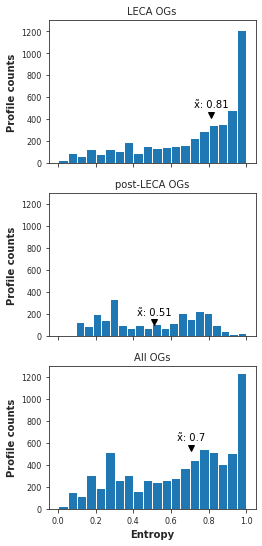

In [172]:
import statistics as s
import scipy.stats as ss

import numpy as np
#plot entropies
fig, ax = plt.subplots(3,1,figsize = (0.5*max_width,max_width), sharex = True,\
                       sharey = True)
color = ["#44AA99", "#EE6677", "#AA3377"]
titles = ["LECA OGs", "post-LECA OGs", "All OGs"]
entropies = [e_l_HSAP, e_pl_HSAP, e_a_HSAP]
print(ss.kruskal(entropies[0], entropies[1], entropies[2]))
print(ss.mannwhitneyu(entropies[0], entropies[1]))
print(ss.mannwhitneyu(entropies[0], entropies[2]))
print(ss.mannwhitneyu(entropies[1], entropies[2]))

for i in range(len(entropies)):
    #histogram of entropy counts
    (n, bins, _) = ax[i].hist(entropies[i], bins=20, label=titles[i])
    ax[i].set_title(titles[i], fontsize = 10)
    #annotate with median
    med = s.median(entropies[i])
    height = n[np.where(bins == min(bins, key=lambda x:abs(x-med)))[0]]
    height_loc = height + 0.25*height
    #plot annotation
    print(height_loc)
    ax[i].plot(med, height_loc, color = "black",marker = "v")
    ax[i].text(med, height_loc+ min(n)*2,"x̃: "+str(round(med,2)), ha = "center", va = "bottom",\
               fontsize = 10, color = "black")
    ax[i].set_ylabel("Profile counts", fontweight = "bold", fontsize = 10)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
fig.tight_layout()


ax[2].set_xlabel("Entropy", fontweight = "bold", fontsize = 10)

plt.savefig("SupplementaryFig6A.pdf", bbox_inches = 'tight',pad_inches = 0.1)

LECA (initial) set 1191
Post-LECA OGs 462


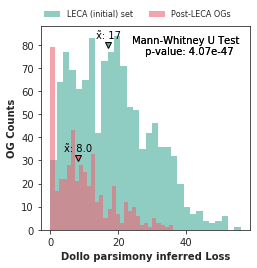

In [164]:
#### loss distributions of OGs participating in interactions

#Mann-Whitney U Test to test if distributions are equal or not
#Interpretation

#    H0: the distributions of both samples are equal o that there is a 50% 
#probability that an observation from a value randomly selected from one population 
#exceeds an observation randomly selected from the other population.
#    H1: the distributions of both samples are not equal.
#If the P value is small, you can reject the null hypothesis that the difference 
#is due to random sampling, and conclude instead that the populations are distinct.

import scipy.stats as ss
#nums = ["I.", "II.", "III."]
colors = ["#44AA99", "#EE6677"]
labels = ["LECA (initial) set", "Post-LECA OGs"]

int_set = pd.concat([pos_set_leca["OG_A"], pos_set_leca["OG_B"]])
LECA_loss_int = LECA_loss[LECA_loss.index.isin(int_set)]


int_set_post = pd.concat([pos_set_post_leca["OG_A"], pos_set_post_leca["OG_B"]])
nonLECA_loss_int = nonLECA_loss[nonLECA_loss.index.isin(int_set_post)]

data = [LECA_loss_int, nonLECA_loss_int]
_,p = ss.mannwhitneyu(data[0], data[1])


fig, ax = plt.subplots(1,1, figsize = (0.5*max_width, 0.5*max_width))
for i in range(len(data)):
    print(labels[i], len(data[i]))
    (n, bins, _) = ax.hist(data[i], bins=30, color = colors[i],\
                                 alpha = 0.6, linewidth = 0, edgecolor = None, label = labels[i])
    
    med = s.median(data[i])
    height = n[np.where(bins == min(bins, key=lambda x:abs(x-med)))[0]]
    height_loc = height + 3
    
    #plot annotation
    ax.plot(med, height_loc, markerfacecolor = colors[i], color = "black", marker = "v")
    ax.text(med, height_loc + 2,"x̃: "+ str(round(med,2)), va = "bottom", ha = "center",\
                color = "black", fontsize = 10)
    ax.text(0.7, 0.85,"Mann-Whitney U Test \n p-value: " + '{:0.2e}'.format(p), va = "bottom", ha = "center",\
                color = "black", fontsize = 10, transform=ax.transAxes)

ax.set_ylabel("OG Counts", fontweight = "bold", fontsize = 10)
ax.set_xlabel("Dollo parsimony inferred Loss", fontweight = "bold", fontsize = 10)
ax.legend(bbox_to_anchor = (0., 1.02), borderaxespad=0., ncol = 2, frameon = False,\
             prop={'size': 8}, loc='lower left')
plt.savefig("SupplementaryFig8A.pdf", bbox_inches = 'tight',pad_inches = 0.1)

In [119]:
#get counts of interactions of HSAP and SCER

count_dict_species_HSAP_df = pd.DataFrame.from_dict(count_dict_species_HSAP, orient = 'index')
count_dict_species_SCER_df = pd.DataFrame.from_dict(count_dict_species_SCER, orient = 'index')

e_l_SCER = entropy_profiles(profile_leca, pos_set_leca_SCER,\
                            neg_set_leca_SCER, "SCER")


1.676693575351055e-32
1.676693575351055e-32
2.406558916349707e-46
2.406558916349707e-46


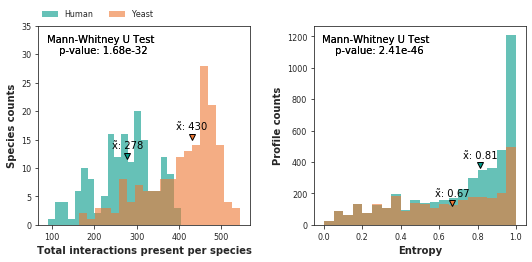

In [163]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as s
import seaborn as sns

sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(1,2, figsize = (max_width, 0.5*max_width))

#counts species and total interactions
colors = ["#009988","#EE7733"]
counts_d = [count_dict_species_HSAP_df["present"], count_dict_species_SCER_df["present"]]
entropies = [e_l_HSAP, e_l_SCER]
x_labels = ["Total interactions present per species", "Entropy"]
y_labels = ["Species counts", "Profile counts"]
labels = ["Human", "Yeast"]
def make_hist_plot(information_input, colors, ax, labels, x_labels, y_labels):
    for i in range(len(information_input)):
        #histogram of entropy counts
        (n, bins, _) = ax.hist(information_input[i], bins=20, color = colors[i],\
                                 alpha = 0.6, linewidth = 0, edgecolor = None, label = labels[i])
        
        #annotate with median
        med = s.median(information_input[i])
        height = n[np.where(bins == min(bins, key=lambda x:abs(x-med)))[0]]
        height_loc = height + 0.1*height
        #plot annotation
        _,p = ss.mannwhitneyu(information_input[0], information_input[1])
        print(p)
        ax.plot(med, height_loc, markerfacecolor = colors[i], color = "black", marker = "v")
        ax.text(med, height_loc + min(n),"x̃: "+ str(round(med,2)), va = "bottom", ha = "center",\
                color = "black", fontsize = 10)
        ax.text(0.3, 0.85,"Mann-Whitney U Test \n p-value: " + '{:0.2e}'.format(p), va = "bottom", ha = "center",\
                color = "black", fontsize = 10, transform=ax.transAxes)
        ax.set_xlabel(x_labels, fontweight = "bold", fontsize = 10)
        ax.set_ylabel(y_labels, fontweight = "bold", fontsize = 10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        
make_hist_plot(counts_d, colors, ax[0], labels, x_labels[0], y_labels[0])
make_hist_plot(entropies, colors, ax[1], labels, x_labels[1], y_labels[1])

ax[0].set_ylim([0,35])

ax[0].legend(bbox_to_anchor = (0., 1.02), borderaxespad=0., ncol = 2, frameon = False,\
             prop={'size': 8}, loc='lower left')
plt.tight_layout()

plt.savefig("SupplementaryFig11A.pdf", bbox_inches = 'tight',pad_inches = 0.1)

In [173]:
###which of the interactors have one in leca and the other not in leca
positive_file = "./Sonicparanoid_sensitive_biogrid"
pos_setr = pd.read_csv(positive_file, sep = "\t")
pos_set = pos_setr[["OG_A", "OG_B"]]

track_d = {}
for idx in range(0, len(pos_set)):
    OG_A = pos_set.iloc[idx, 0]
    OG_B = pos_set.iloc[idx, 1]
    if OG_A != OG_B: #don't use OGs that bind to themselves (distance would be 0 because profiles are the same)   
        if OG_A != "-" and OG_B != "-":
            if (OG_A, OG_B) not in track_d:
                if (OG_B, OG_A) not in track_d:
                    #print(OG_A, OG_B)
                    if OG_A in list(leca[0]) and OG_B not in list(leca[0]):
                        track_d[(OG_A,OG_B)] = True #just to keep track
                    elif OG_A not in list(leca[0]) and OG_B in list(leca[0]):
                        track_d[(OG_A,OG_B)] = True #just to keep track


In [174]:
int_df_part_leca = pd.DataFrame(index = range(len(track_d)),\
                                columns = ["leca og", "non-leca og", "p1", "p2"])
i = 0

int_half_in_leca_d = {}

for key_pair in track_d:
    og1 = key_pair[0]
    og2 = key_pair[1]
    if og1 in list(leca[0]):
        if og1 not in int_half_in_leca_d:
            int_half_in_leca_d[og1] = {}
            int_half_in_leca_d[og1][og2] = True
        else:
            int_half_in_leca_d[og1][og2] = True
    elif og2 in list(leca[0]):
        if og2 not in int_half_in_leca_d:
            int_half_in_leca_d[og2] = {}
            int_half_in_leca_d[og2][og1] = True
        else:
            int_half_in_leca_d[og2][og1] = True

    i += 1
    

838


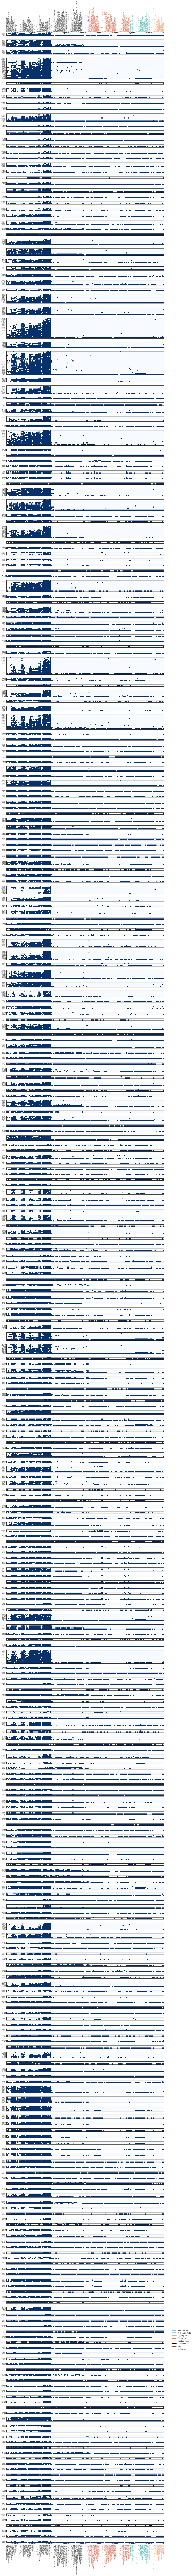

In [188]:
#plot OG pairs for which on is in leca and the other is not
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as sm
from matplotlib.lines import Line2D

#presort profiles according to species tree
profile_s = profile[leaves] 
#make a length list to manually change size of subplots
len_list = []
for leca_og, ogs in int_half_in_leca_d.items():
    profile_list = []
    profile_list += [profile_s.loc[leca_og]]
    profile_list += [profile_s.loc[og] for og in list(ogs.keys())]
    len_list += [len(profile_list)]

fig, ax = plt.subplots(len(int_half_in_leca_d), figsize = [13, 200],\
                           gridspec_kw={'height_ratios':len_list})
row=0

#plot all groups of OGs that interact with a leca OG
for leca_og, ogs in int_half_in_leca_d.items():
    profile_list = []
    profile_list_nonleca = []
    
    profile_list += [profile_s.loc[leca_og]]
    profile_list += [profile_s.loc[og] for og in list(ogs.keys())]
    #cluster the profiles with leca and sort
    pwd_profiles = sm.pairwise_distances(profile_list, metric = 'cosine')
    sort_index = np.argsort(pwd_profiles[0])
    profile_list = [profile_list[x] for x in sort_index]
    g = ax[row].imshow(profile_list,\
                       aspect = "auto", origin='lower', cmap = "Blues") #Blues #viridis_r #YlGnBu
    #y ticks and labels
    ax[row].set_yticks([x for x in range(len(profile_list))])
    names = [leca_og] + [og for og in list(ogs.keys())]
    ax[row].set_yticklabels(names, fontsize = 6)
    
    #x ticks and labels
    if row not in [0,len(int_half_in_leca_d)-1]:
        ax[row].axes.xaxis.set_visible(False)
    else:
        ax[row].set_xticks(range(len(profile_s.columns)))
        ax[row].set_xticklabels([species_names[x] for x in leaves], rotation = 90, size = 6)
    row += 1
    
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top') 
ax[0].tick_params(labelbottom=False,labeltop=True)
plt.tight_layout()

#colur names of 
for i in range(0, len(ax[0].get_xticklabels())):
    ax[0].get_xticklabels()[i].set_color(color_list[i])
    ax[len(int_half_in_leca_d)-1].get_xticklabels()[i].set_color(color_list[i])

#add custom legend for supergroups
spg = [x for x in sorted(list(color_supergrd.keys()))]
cls = [color_supergrd[x] for x in spg]
custom_lines = [Line2D([0], [0], color=cls[i], lw=4) for i in range(len(cls))]
plt.legend(custom_lines, spg, loc="center left", bbox_to_anchor=(1.05,100),
       ncol=1, borderaxespad=0., prop = {"size": 10})


plt.savefig("SupplementaryFig9.pdf", bbox_inches = 'tight',pad_inches = 0)